In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from torch.utils.data import Dataset, random_split
from GTZAN import GTZAN
import numpy as np
import matplotlib.pyplot as plt
import librosa
import datetime

sr = 44100
hl = 512

In [2]:
device = torch.device('cuda')
print(device)
print(torch.cuda.is_available())

cuda
True


In [3]:
dataset = GTZAN()
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size
trainset, validset = random_split(dataset, [train_size, valid_size])

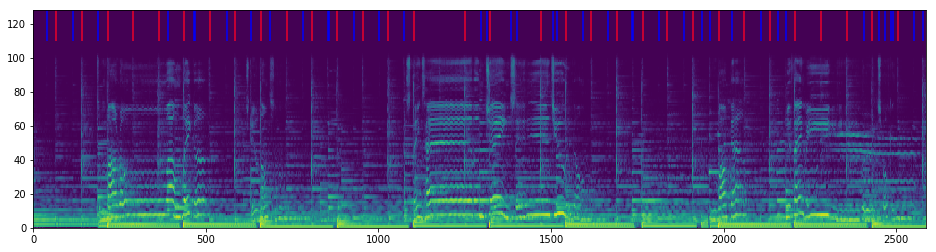

In [4]:
spec, onsets, isbeat = trainset[np.random.randint(len(trainset))]

plt.figure(figsize=(16, 4))
plt.vlines(onsets, 110, 128, color='b')
plt.vlines(onsets[isbeat==1],  110, 128, color='r')
plt.ylim(0, 128)
plt.pcolormesh(spec);

In [45]:
class BeatTracker(nn.Module):
    def __init__(self, hidden_size=128, num_layers=2, n_mels=128):
        super(BeatTracker, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(n_mels, hidden_size, num_layers, bidirectional=True)
        self.hid_to_beat = nn.Linear(2 * hidden_size, 2)
        self.hidden = self.init_hidden()
        
        self.loss_function = nn.NLLLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)
    def init_hidden(self):
        h0 = torch.zeros(2 * self.num_layers, 1, self.hidden_size).cuda()
        c0 = torch.zeros(2 * self.num_layers, 1, self.hidden_size).cuda()
        return h0, c0
    def forward(self, spec, onsets):
        x, self.hidden = self.lstm(spec, self.hidden)
        x = self.hid_to_beat(x)
        x = F.log_softmax(x, dim=-1)
        return x[onsets]
    def fit(self, spec, onsets, isbeat):
        self.hidden = self.init_hidden()
        self.optimizer.zero_grad()
        output = self(spec, onsets)
        loss = self.loss_function(output.squeeze(1), isbeat)
        loss.backward()
        self.optimizer.step()
        return loss.item()
    def accuracy(self, dataset):
        with torch.no_grad():
            acc = 0
            for n in range(len(dataset)):
                spec, onsets, isbeat = totensor(*dataset[n])
                output = model(spec, onsets)
                gotit = torch.sum(torch.argmax(output, dim=-1).squeeze(1) == isbeat).item()
                acc += gotit / len(onsets)
            acc /= len(dataset)
        return acc

def totensor(spec_np, onsets_np, isbeat_np):
    spec   = torch.tensor(spec_np.T, dtype=torch.float).unsqueeze(1).cuda()
    onsets = torch.tensor(onsets_np, dtype=torch.long).cuda()
    isbeat = torch.tensor(isbeat_np, dtype=torch.long).cuda()
    return spec, onsets, isbeat

In [9]:
%%time
idxs = np.random.permutation(len(trainset))
for i in idxs:
    spec, onsets, isbeat = totensor(*trainset[i])

CPU times: user 3 s, sys: 476 ms, total: 3.48 s
Wall time: 3.47 s


In [46]:
model = BeatTracker()
model.cuda()

BeatTracker(
  (lstm): LSTM(128, 128, num_layers=2, bidirectional=True)
  (hid_to_beat): Linear(in_features=256, out_features=2, bias=True)
  (loss_function): NLLLoss()
)

In [47]:
model.accuracy(validset)

0.3310754062768998

In [48]:
epochs = 10
size = len(trainset)
hist = np.zeros((size, epochs))

average_time = None

for e in range(epochs):
    idxs = np.random.permutation(len(trainset))
    size = len(idxs)
    for i, n in enumerate(idxs):
        start = time.time()
        spec, onsets, isbeat = totensor(*trainset[n])
        loss = model.fit(spec, onsets, isbeat)
        hist[i, e] = loss
        end = time.time()
        if average_time == None:
            average_time = (end - start)
        else:
            average_time = (i * average_time + (end - start)) / (i + 1)
        tot = str(datetime.timedelta(seconds=int(average_time * epochs * size)))
        eta = str(datetime.timedelta(seconds=int(average_time * (epochs * size - (i + 1) * (e + 1)))))
        print(f'| Epoch {e + 1:{len(str(epochs))}d}/{epochs} ', end='')
        print(f'|{100 * (i + 1) / size:6.2f}% ', end='')
        print(f'| {i + 1:{len(str(size))}d}/{size} ', end='')
        print(f'| Loss = {loss:.4f} | time = {average_time:.2f} | tot: {tot} | eta: {eta} |')

| Epoch  1/10 |  0.12% |   1/800 | Loss = 0.7020 | time = 0.26 | tot: 0:34:45 | eta: 0:34:45 |
| Epoch  1/10 |  0.25% |   2/800 | Loss = 0.6805 | time = 0.27 | tot: 0:35:34 | eta: 0:35:34 |
| Epoch  1/10 |  0.38% |   3/800 | Loss = 0.6651 | time = 0.26 | tot: 0:35:01 | eta: 0:35:01 |
| Epoch  1/10 |  0.50% |   4/800 | Loss = 0.5439 | time = 0.27 | tot: 0:35:28 | eta: 0:35:27 |
| Epoch  1/10 |  0.62% |   5/800 | Loss = 0.5083 | time = 0.26 | tot: 0:34:51 | eta: 0:34:50 |
| Epoch  1/10 |  0.75% |   6/800 | Loss = 0.8928 | time = 0.26 | tot: 0:34:39 | eta: 0:34:37 |
| Epoch  1/10 |  0.88% |   7/800 | Loss = 0.6212 | time = 0.26 | tot: 0:34:45 | eta: 0:34:43 |
| Epoch  1/10 |  1.00% |   8/800 | Loss = 0.2963 | time = 0.26 | tot: 0:34:41 | eta: 0:34:39 |
| Epoch  1/10 |  1.12% |   9/800 | Loss = 0.6710 | time = 0.26 | tot: 0:34:32 | eta: 0:34:29 |
| Epoch  1/10 |  1.25% |  10/800 | Loss = 0.4206 | time = 0.26 | tot: 0:34:29 | eta: 0:34:27 |
| Epoch  1/10 |  1.38% |  11/800 | Loss = 0.5482 |

| Epoch  1/10 | 11.00% |  88/800 | Loss = 0.5782 | time = 0.27 | tot: 0:35:35 | eta: 0:35:12 |
| Epoch  1/10 | 11.12% |  89/800 | Loss = 0.6425 | time = 0.27 | tot: 0:35:36 | eta: 0:35:12 |
| Epoch  1/10 | 11.25% |  90/800 | Loss = 0.4400 | time = 0.27 | tot: 0:35:37 | eta: 0:35:13 |
| Epoch  1/10 | 11.38% |  91/800 | Loss = 0.7662 | time = 0.27 | tot: 0:35:37 | eta: 0:35:13 |
| Epoch  1/10 | 11.50% |  92/800 | Loss = 0.4958 | time = 0.27 | tot: 0:35:38 | eta: 0:35:13 |
| Epoch  1/10 | 11.62% |  93/800 | Loss = 0.4257 | time = 0.27 | tot: 0:35:38 | eta: 0:35:13 |
| Epoch  1/10 | 11.75% |  94/800 | Loss = 0.4073 | time = 0.27 | tot: 0:35:39 | eta: 0:35:14 |
| Epoch  1/10 | 11.88% |  95/800 | Loss = 0.8759 | time = 0.27 | tot: 0:35:41 | eta: 0:35:15 |
| Epoch  1/10 | 12.00% |  96/800 | Loss = 0.8093 | time = 0.27 | tot: 0:35:41 | eta: 0:35:15 |
| Epoch  1/10 | 12.12% |  97/800 | Loss = 0.6252 | time = 0.27 | tot: 0:35:41 | eta: 0:35:15 |
| Epoch  1/10 | 12.25% |  98/800 | Loss = 0.5153 |

| Epoch  1/10 | 21.88% | 175/800 | Loss = 0.4045 | time = 0.27 | tot: 0:36:00 | eta: 0:35:13 |
| Epoch  1/10 | 22.00% | 176/800 | Loss = 0.3665 | time = 0.27 | tot: 0:36:01 | eta: 0:35:14 |
| Epoch  1/10 | 22.12% | 177/800 | Loss = 0.8165 | time = 0.27 | tot: 0:36:02 | eta: 0:35:14 |
| Epoch  1/10 | 22.25% | 178/800 | Loss = 0.3817 | time = 0.27 | tot: 0:36:02 | eta: 0:35:14 |
| Epoch  1/10 | 22.38% | 179/800 | Loss = 0.6597 | time = 0.27 | tot: 0:36:03 | eta: 0:35:14 |
| Epoch  1/10 | 22.50% | 180/800 | Loss = 0.5645 | time = 0.27 | tot: 0:36:03 | eta: 0:35:14 |
| Epoch  1/10 | 22.62% | 181/800 | Loss = 0.6646 | time = 0.27 | tot: 0:36:03 | eta: 0:35:14 |
| Epoch  1/10 | 22.75% | 182/800 | Loss = 0.6783 | time = 0.27 | tot: 0:36:03 | eta: 0:35:14 |
| Epoch  1/10 | 22.88% | 183/800 | Loss = 0.4578 | time = 0.27 | tot: 0:36:05 | eta: 0:35:15 |
| Epoch  1/10 | 23.00% | 184/800 | Loss = 0.4855 | time = 0.27 | tot: 0:36:05 | eta: 0:35:15 |
| Epoch  1/10 | 23.12% | 185/800 | Loss = 0.6128 |

| Epoch  1/10 | 32.75% | 262/800 | Loss = 0.5702 | time = 0.27 | tot: 0:36:37 | eta: 0:35:25 |
| Epoch  1/10 | 32.88% | 263/800 | Loss = 0.4236 | time = 0.27 | tot: 0:36:37 | eta: 0:35:25 |
| Epoch  1/10 | 33.00% | 264/800 | Loss = 0.2757 | time = 0.27 | tot: 0:36:37 | eta: 0:35:25 |
| Epoch  1/10 | 33.12% | 265/800 | Loss = 0.5146 | time = 0.27 | tot: 0:36:38 | eta: 0:35:25 |
| Epoch  1/10 | 33.25% | 266/800 | Loss = 0.4028 | time = 0.27 | tot: 0:36:38 | eta: 0:35:25 |
| Epoch  1/10 | 33.38% | 267/800 | Loss = 0.4506 | time = 0.27 | tot: 0:36:39 | eta: 0:35:25 |
| Epoch  1/10 | 33.50% | 268/800 | Loss = 0.6127 | time = 0.27 | tot: 0:36:39 | eta: 0:35:25 |
| Epoch  1/10 | 33.62% | 269/800 | Loss = 0.6793 | time = 0.27 | tot: 0:36:39 | eta: 0:35:25 |
| Epoch  1/10 | 33.75% | 270/800 | Loss = 0.4803 | time = 0.28 | tot: 0:36:40 | eta: 0:35:25 |
| Epoch  1/10 | 33.88% | 271/800 | Loss = 0.3231 | time = 0.28 | tot: 0:36:40 | eta: 0:35:26 |
| Epoch  1/10 | 34.00% | 272/800 | Loss = 0.1274 |

| Epoch  1/10 | 43.62% | 349/800 | Loss = 0.2315 | time = 0.28 | tot: 0:36:44 | eta: 0:35:08 |
| Epoch  1/10 | 43.75% | 350/800 | Loss = 0.4193 | time = 0.28 | tot: 0:36:44 | eta: 0:35:07 |
| Epoch  1/10 | 43.88% | 351/800 | Loss = 0.4999 | time = 0.28 | tot: 0:36:44 | eta: 0:35:07 |
| Epoch  1/10 | 44.00% | 352/800 | Loss = 0.4565 | time = 0.28 | tot: 0:36:43 | eta: 0:35:06 |
| Epoch  1/10 | 44.12% | 353/800 | Loss = 0.4966 | time = 0.28 | tot: 0:36:43 | eta: 0:35:06 |
| Epoch  1/10 | 44.25% | 354/800 | Loss = 0.4303 | time = 0.28 | tot: 0:36:44 | eta: 0:35:07 |
| Epoch  1/10 | 44.38% | 355/800 | Loss = 0.4452 | time = 0.28 | tot: 0:36:44 | eta: 0:35:06 |
| Epoch  1/10 | 44.50% | 356/800 | Loss = 0.4646 | time = 0.28 | tot: 0:36:44 | eta: 0:35:06 |
| Epoch  1/10 | 44.62% | 357/800 | Loss = 0.5468 | time = 0.28 | tot: 0:36:43 | eta: 0:35:05 |
| Epoch  1/10 | 44.75% | 358/800 | Loss = 0.4938 | time = 0.28 | tot: 0:36:43 | eta: 0:35:05 |
| Epoch  1/10 | 44.88% | 359/800 | Loss = 0.6150 |

| Epoch  1/10 | 54.50% | 436/800 | Loss = 0.5200 | time = 0.28 | tot: 0:36:41 | eta: 0:34:41 |
| Epoch  1/10 | 54.62% | 437/800 | Loss = 0.4312 | time = 0.28 | tot: 0:36:41 | eta: 0:34:40 |
| Epoch  1/10 | 54.75% | 438/800 | Loss = 0.4838 | time = 0.28 | tot: 0:36:41 | eta: 0:34:40 |
| Epoch  1/10 | 54.88% | 439/800 | Loss = 0.7278 | time = 0.28 | tot: 0:36:41 | eta: 0:34:40 |
| Epoch  1/10 | 55.00% | 440/800 | Loss = 0.5006 | time = 0.28 | tot: 0:36:40 | eta: 0:34:39 |
| Epoch  1/10 | 55.12% | 441/800 | Loss = 0.1712 | time = 0.28 | tot: 0:36:40 | eta: 0:34:39 |
| Epoch  1/10 | 55.25% | 442/800 | Loss = 0.5095 | time = 0.28 | tot: 0:36:40 | eta: 0:34:39 |
| Epoch  1/10 | 55.38% | 443/800 | Loss = 0.5263 | time = 0.28 | tot: 0:36:40 | eta: 0:34:38 |
| Epoch  1/10 | 55.50% | 444/800 | Loss = 0.4189 | time = 0.28 | tot: 0:36:40 | eta: 0:34:38 |
| Epoch  1/10 | 55.62% | 445/800 | Loss = 0.5217 | time = 0.28 | tot: 0:36:40 | eta: 0:34:38 |
| Epoch  1/10 | 55.75% | 446/800 | Loss = 0.3882 |

| Epoch  1/10 | 65.38% | 523/800 | Loss = 0.1396 | time = 0.27 | tot: 0:36:34 | eta: 0:34:11 |
| Epoch  1/10 | 65.50% | 524/800 | Loss = 0.2479 | time = 0.27 | tot: 0:36:34 | eta: 0:34:11 |
| Epoch  1/10 | 65.62% | 525/800 | Loss = 0.5071 | time = 0.27 | tot: 0:36:34 | eta: 0:34:10 |
| Epoch  1/10 | 65.75% | 526/800 | Loss = 0.4305 | time = 0.27 | tot: 0:36:34 | eta: 0:34:10 |
| Epoch  1/10 | 65.88% | 527/800 | Loss = 0.4482 | time = 0.27 | tot: 0:36:34 | eta: 0:34:10 |
| Epoch  1/10 | 66.00% | 528/800 | Loss = 1.0393 | time = 0.27 | tot: 0:36:34 | eta: 0:34:09 |
| Epoch  1/10 | 66.12% | 529/800 | Loss = 0.3903 | time = 0.27 | tot: 0:36:34 | eta: 0:34:09 |
| Epoch  1/10 | 66.25% | 530/800 | Loss = 0.6363 | time = 0.27 | tot: 0:36:34 | eta: 0:34:09 |
| Epoch  1/10 | 66.38% | 531/800 | Loss = 0.4054 | time = 0.27 | tot: 0:36:34 | eta: 0:34:09 |
| Epoch  1/10 | 66.50% | 532/800 | Loss = 0.8343 | time = 0.27 | tot: 0:36:34 | eta: 0:34:08 |
| Epoch  1/10 | 66.62% | 533/800 | Loss = 0.2463 |

| Epoch  1/10 | 76.25% | 610/800 | Loss = 0.5764 | time = 0.27 | tot: 0:36:26 | eta: 0:33:40 |
| Epoch  1/10 | 76.38% | 611/800 | Loss = 0.4561 | time = 0.27 | tot: 0:36:26 | eta: 0:33:39 |
| Epoch  1/10 | 76.50% | 612/800 | Loss = 0.5355 | time = 0.27 | tot: 0:36:26 | eta: 0:33:39 |
| Epoch  1/10 | 76.62% | 613/800 | Loss = 0.5317 | time = 0.27 | tot: 0:36:26 | eta: 0:33:39 |
| Epoch  1/10 | 76.75% | 614/800 | Loss = 0.6290 | time = 0.27 | tot: 0:36:27 | eta: 0:33:39 |
| Epoch  1/10 | 76.88% | 615/800 | Loss = 0.4492 | time = 0.27 | tot: 0:36:27 | eta: 0:33:39 |
| Epoch  1/10 | 77.00% | 616/800 | Loss = 0.6858 | time = 0.27 | tot: 0:36:27 | eta: 0:33:38 |
| Epoch  1/10 | 77.12% | 617/800 | Loss = 0.2158 | time = 0.27 | tot: 0:36:27 | eta: 0:33:38 |
| Epoch  1/10 | 77.25% | 618/800 | Loss = 0.6980 | time = 0.27 | tot: 0:36:27 | eta: 0:33:38 |
| Epoch  1/10 | 77.38% | 619/800 | Loss = 0.5569 | time = 0.27 | tot: 0:36:27 | eta: 0:33:38 |
| Epoch  1/10 | 77.50% | 620/800 | Loss = 0.7588 |

| Epoch  1/10 | 87.12% | 697/800 | Loss = 0.4197 | time = 0.27 | tot: 0:36:22 | eta: 0:33:12 |
| Epoch  1/10 | 87.25% | 698/800 | Loss = 0.5803 | time = 0.27 | tot: 0:36:21 | eta: 0:33:11 |
| Epoch  1/10 | 87.38% | 699/800 | Loss = 0.5986 | time = 0.27 | tot: 0:36:21 | eta: 0:33:10 |
| Epoch  1/10 | 87.50% | 700/800 | Loss = 0.4755 | time = 0.27 | tot: 0:36:21 | eta: 0:33:10 |
| Epoch  1/10 | 87.62% | 701/800 | Loss = 0.5064 | time = 0.27 | tot: 0:36:21 | eta: 0:33:09 |
| Epoch  1/10 | 87.75% | 702/800 | Loss = 0.2839 | time = 0.27 | tot: 0:36:21 | eta: 0:33:09 |
| Epoch  1/10 | 87.88% | 703/800 | Loss = 0.6173 | time = 0.27 | tot: 0:36:21 | eta: 0:33:09 |
| Epoch  1/10 | 88.00% | 704/800 | Loss = 0.2304 | time = 0.27 | tot: 0:36:21 | eta: 0:33:09 |
| Epoch  1/10 | 88.12% | 705/800 | Loss = 0.2569 | time = 0.27 | tot: 0:36:21 | eta: 0:33:08 |
| Epoch  1/10 | 88.25% | 706/800 | Loss = 0.7128 | time = 0.27 | tot: 0:36:20 | eta: 0:33:08 |
| Epoch  1/10 | 88.38% | 707/800 | Loss = 0.5922 |

| Epoch  1/10 | 98.00% | 784/800 | Loss = 0.1711 | time = 0.27 | tot: 0:36:20 | eta: 0:32:47 |
| Epoch  1/10 | 98.12% | 785/800 | Loss = 0.3231 | time = 0.27 | tot: 0:36:20 | eta: 0:32:46 |
| Epoch  1/10 | 98.25% | 786/800 | Loss = 0.4404 | time = 0.27 | tot: 0:36:20 | eta: 0:32:46 |
| Epoch  1/10 | 98.38% | 787/800 | Loss = 0.2565 | time = 0.27 | tot: 0:36:20 | eta: 0:32:46 |
| Epoch  1/10 | 98.50% | 788/800 | Loss = 0.3614 | time = 0.27 | tot: 0:36:20 | eta: 0:32:45 |
| Epoch  1/10 | 98.62% | 789/800 | Loss = 0.4651 | time = 0.27 | tot: 0:36:20 | eta: 0:32:45 |
| Epoch  1/10 | 98.75% | 790/800 | Loss = 0.5437 | time = 0.27 | tot: 0:36:20 | eta: 0:32:45 |
| Epoch  1/10 | 98.88% | 791/800 | Loss = 0.3387 | time = 0.27 | tot: 0:36:20 | eta: 0:32:44 |
| Epoch  1/10 | 99.00% | 792/800 | Loss = 1.1015 | time = 0.27 | tot: 0:36:20 | eta: 0:32:44 |
| Epoch  1/10 | 99.12% | 793/800 | Loss = 0.6930 | time = 0.27 | tot: 0:36:20 | eta: 0:32:44 |
| Epoch  1/10 | 99.25% | 794/800 | Loss = 0.1123 |

| Epoch  2/10 |  8.88% |  71/800 | Loss = 0.4996 | time = 0.27 | tot: 0:36:03 | eta: 0:35:24 |
| Epoch  2/10 |  9.00% |  72/800 | Loss = 0.6744 | time = 0.27 | tot: 0:36:02 | eta: 0:35:23 |
| Epoch  2/10 |  9.12% |  73/800 | Loss = 0.4954 | time = 0.27 | tot: 0:36:01 | eta: 0:35:21 |
| Epoch  2/10 |  9.25% |  74/800 | Loss = 0.5884 | time = 0.27 | tot: 0:36:00 | eta: 0:35:20 |
| Epoch  2/10 |  9.38% |  75/800 | Loss = 0.5482 | time = 0.27 | tot: 0:36:00 | eta: 0:35:19 |
| Epoch  2/10 |  9.50% |  76/800 | Loss = 0.2189 | time = 0.27 | tot: 0:35:59 | eta: 0:35:18 |
| Epoch  2/10 |  9.62% |  77/800 | Loss = 0.6537 | time = 0.27 | tot: 0:35:58 | eta: 0:35:17 |
| Epoch  2/10 |  9.75% |  78/800 | Loss = 0.4995 | time = 0.27 | tot: 0:35:57 | eta: 0:35:15 |
| Epoch  2/10 |  9.88% |  79/800 | Loss = 0.4641 | time = 0.27 | tot: 0:35:57 | eta: 0:35:14 |
| Epoch  2/10 | 10.00% |  80/800 | Loss = 0.5697 | time = 0.27 | tot: 0:35:55 | eta: 0:35:12 |
| Epoch  2/10 | 10.12% |  81/800 | Loss = 0.3380 |

| Epoch  2/10 | 19.75% | 158/800 | Loss = 1.0023 | time = 0.27 | tot: 0:35:45 | eta: 0:34:21 |
| Epoch  2/10 | 19.88% | 159/800 | Loss = 0.3565 | time = 0.27 | tot: 0:35:45 | eta: 0:34:20 |
| Epoch  2/10 | 20.00% | 160/800 | Loss = 0.4057 | time = 0.27 | tot: 0:35:45 | eta: 0:34:19 |
| Epoch  2/10 | 20.12% | 161/800 | Loss = 0.4585 | time = 0.27 | tot: 0:35:45 | eta: 0:34:19 |
| Epoch  2/10 | 20.25% | 162/800 | Loss = 0.7273 | time = 0.27 | tot: 0:35:46 | eta: 0:34:19 |
| Epoch  2/10 | 20.38% | 163/800 | Loss = 0.3296 | time = 0.27 | tot: 0:35:46 | eta: 0:34:19 |
| Epoch  2/10 | 20.50% | 164/800 | Loss = 0.4674 | time = 0.27 | tot: 0:35:47 | eta: 0:34:19 |
| Epoch  2/10 | 20.62% | 165/800 | Loss = 0.1718 | time = 0.27 | tot: 0:35:47 | eta: 0:34:18 |
| Epoch  2/10 | 20.75% | 166/800 | Loss = 0.7624 | time = 0.27 | tot: 0:35:46 | eta: 0:34:17 |
| Epoch  2/10 | 20.88% | 167/800 | Loss = 0.5391 | time = 0.27 | tot: 0:35:46 | eta: 0:34:16 |
| Epoch  2/10 | 21.00% | 168/800 | Loss = 0.2510 |

| Epoch  2/10 | 30.62% | 245/800 | Loss = 0.6564 | time = 0.27 | tot: 0:35:33 | eta: 0:33:22 |
| Epoch  2/10 | 30.75% | 246/800 | Loss = 0.3685 | time = 0.27 | tot: 0:35:32 | eta: 0:33:21 |
| Epoch  2/10 | 30.88% | 247/800 | Loss = 0.5793 | time = 0.27 | tot: 0:35:32 | eta: 0:33:20 |
| Epoch  2/10 | 31.00% | 248/800 | Loss = 0.3970 | time = 0.27 | tot: 0:35:32 | eta: 0:33:20 |
| Epoch  2/10 | 31.12% | 249/800 | Loss = 0.1649 | time = 0.27 | tot: 0:35:32 | eta: 0:33:19 |
| Epoch  2/10 | 31.25% | 250/800 | Loss = 0.5393 | time = 0.27 | tot: 0:35:32 | eta: 0:33:18 |
| Epoch  2/10 | 31.38% | 251/800 | Loss = 0.4267 | time = 0.27 | tot: 0:35:32 | eta: 0:33:18 |
| Epoch  2/10 | 31.50% | 252/800 | Loss = 0.4348 | time = 0.27 | tot: 0:35:33 | eta: 0:33:18 |
| Epoch  2/10 | 31.62% | 253/800 | Loss = 0.6048 | time = 0.27 | tot: 0:35:33 | eta: 0:33:18 |
| Epoch  2/10 | 31.75% | 254/800 | Loss = 0.1680 | time = 0.27 | tot: 0:35:33 | eta: 0:33:17 |
| Epoch  2/10 | 31.88% | 255/800 | Loss = 0.1037 |

| Epoch  2/10 | 41.50% | 332/800 | Loss = 0.4694 | time = 0.27 | tot: 0:35:38 | eta: 0:32:40 |
| Epoch  2/10 | 41.62% | 333/800 | Loss = 0.2664 | time = 0.27 | tot: 0:35:38 | eta: 0:32:40 |
| Epoch  2/10 | 41.75% | 334/800 | Loss = 0.6229 | time = 0.27 | tot: 0:35:38 | eta: 0:32:39 |
| Epoch  2/10 | 41.88% | 335/800 | Loss = 0.3978 | time = 0.27 | tot: 0:35:38 | eta: 0:32:39 |
| Epoch  2/10 | 42.00% | 336/800 | Loss = 0.7357 | time = 0.27 | tot: 0:35:39 | eta: 0:32:39 |
| Epoch  2/10 | 42.12% | 337/800 | Loss = 0.6611 | time = 0.27 | tot: 0:35:39 | eta: 0:32:38 |
| Epoch  2/10 | 42.25% | 338/800 | Loss = 0.0738 | time = 0.27 | tot: 0:35:39 | eta: 0:32:38 |
| Epoch  2/10 | 42.38% | 339/800 | Loss = 0.3137 | time = 0.27 | tot: 0:35:39 | eta: 0:32:37 |
| Epoch  2/10 | 42.50% | 340/800 | Loss = 0.4069 | time = 0.27 | tot: 0:35:39 | eta: 0:32:37 |
| Epoch  2/10 | 42.62% | 341/800 | Loss = 0.2038 | time = 0.27 | tot: 0:35:39 | eta: 0:32:36 |
| Epoch  2/10 | 42.75% | 342/800 | Loss = 0.4413 |

| Epoch  2/10 | 52.38% | 419/800 | Loss = 0.4815 | time = 0.27 | tot: 0:35:34 | eta: 0:31:51 |
| Epoch  2/10 | 52.50% | 420/800 | Loss = 0.2997 | time = 0.27 | tot: 0:35:34 | eta: 0:31:50 |
| Epoch  2/10 | 52.62% | 421/800 | Loss = 0.4525 | time = 0.27 | tot: 0:35:34 | eta: 0:31:49 |
| Epoch  2/10 | 52.75% | 422/800 | Loss = 0.1816 | time = 0.27 | tot: 0:35:34 | eta: 0:31:49 |
| Epoch  2/10 | 52.88% | 423/800 | Loss = 0.6575 | time = 0.27 | tot: 0:35:34 | eta: 0:31:48 |
| Epoch  2/10 | 53.00% | 424/800 | Loss = 0.6433 | time = 0.27 | tot: 0:35:34 | eta: 0:31:48 |
| Epoch  2/10 | 53.12% | 425/800 | Loss = 0.3351 | time = 0.27 | tot: 0:35:34 | eta: 0:31:48 |
| Epoch  2/10 | 53.25% | 426/800 | Loss = 0.3130 | time = 0.27 | tot: 0:35:35 | eta: 0:31:47 |
| Epoch  2/10 | 53.38% | 427/800 | Loss = 0.1573 | time = 0.27 | tot: 0:35:35 | eta: 0:31:47 |
| Epoch  2/10 | 53.50% | 428/800 | Loss = 0.5977 | time = 0.27 | tot: 0:35:35 | eta: 0:31:46 |
| Epoch  2/10 | 53.62% | 429/800 | Loss = 0.5402 |

| Epoch  2/10 | 63.25% | 506/800 | Loss = 0.2627 | time = 0.27 | tot: 0:35:38 | eta: 0:31:07 |
| Epoch  2/10 | 63.38% | 507/800 | Loss = 0.3509 | time = 0.27 | tot: 0:35:38 | eta: 0:31:07 |
| Epoch  2/10 | 63.50% | 508/800 | Loss = 0.7642 | time = 0.27 | tot: 0:35:38 | eta: 0:31:06 |
| Epoch  2/10 | 63.62% | 509/800 | Loss = 0.1846 | time = 0.27 | tot: 0:35:38 | eta: 0:31:06 |
| Epoch  2/10 | 63.75% | 510/800 | Loss = 0.2957 | time = 0.27 | tot: 0:35:38 | eta: 0:31:05 |
| Epoch  2/10 | 63.88% | 511/800 | Loss = 0.5572 | time = 0.27 | tot: 0:35:38 | eta: 0:31:05 |
| Epoch  2/10 | 64.00% | 512/800 | Loss = 0.6649 | time = 0.27 | tot: 0:35:38 | eta: 0:31:04 |
| Epoch  2/10 | 64.12% | 513/800 | Loss = 0.0960 | time = 0.27 | tot: 0:35:38 | eta: 0:31:04 |
| Epoch  2/10 | 64.25% | 514/800 | Loss = 0.9610 | time = 0.27 | tot: 0:35:38 | eta: 0:31:03 |
| Epoch  2/10 | 64.38% | 515/800 | Loss = 0.7872 | time = 0.27 | tot: 0:35:39 | eta: 0:31:03 |
| Epoch  2/10 | 64.50% | 516/800 | Loss = 0.7011 |

| Epoch  2/10 | 74.12% | 593/800 | Loss = 0.4151 | time = 0.27 | tot: 0:35:42 | eta: 0:30:24 |
| Epoch  2/10 | 74.25% | 594/800 | Loss = 0.1961 | time = 0.27 | tot: 0:35:42 | eta: 0:30:24 |
| Epoch  2/10 | 74.38% | 595/800 | Loss = 0.2714 | time = 0.27 | tot: 0:35:42 | eta: 0:30:23 |
| Epoch  2/10 | 74.50% | 596/800 | Loss = 0.4685 | time = 0.27 | tot: 0:35:42 | eta: 0:30:23 |
| Epoch  2/10 | 74.62% | 597/800 | Loss = 0.5193 | time = 0.27 | tot: 0:35:43 | eta: 0:30:23 |
| Epoch  2/10 | 74.75% | 598/800 | Loss = 0.1713 | time = 0.27 | tot: 0:35:43 | eta: 0:30:22 |
| Epoch  2/10 | 74.88% | 599/800 | Loss = 0.5842 | time = 0.27 | tot: 0:35:43 | eta: 0:30:22 |
| Epoch  2/10 | 75.00% | 600/800 | Loss = 1.1546 | time = 0.27 | tot: 0:35:43 | eta: 0:30:21 |
| Epoch  2/10 | 75.12% | 601/800 | Loss = 0.4548 | time = 0.27 | tot: 0:35:43 | eta: 0:30:21 |
| Epoch  2/10 | 75.25% | 602/800 | Loss = 0.5285 | time = 0.27 | tot: 0:35:43 | eta: 0:30:20 |
| Epoch  2/10 | 75.38% | 603/800 | Loss = 0.5698 |

| Epoch  2/10 | 85.00% | 680/800 | Loss = 0.3385 | time = 0.27 | tot: 0:35:46 | eta: 0:29:41 |
| Epoch  2/10 | 85.12% | 681/800 | Loss = 0.3523 | time = 0.27 | tot: 0:35:46 | eta: 0:29:41 |
| Epoch  2/10 | 85.25% | 682/800 | Loss = 0.5241 | time = 0.27 | tot: 0:35:46 | eta: 0:29:40 |
| Epoch  2/10 | 85.38% | 683/800 | Loss = 0.4914 | time = 0.27 | tot: 0:35:46 | eta: 0:29:40 |
| Epoch  2/10 | 85.50% | 684/800 | Loss = 0.4185 | time = 0.27 | tot: 0:35:46 | eta: 0:29:39 |
| Epoch  2/10 | 85.62% | 685/800 | Loss = 0.4326 | time = 0.27 | tot: 0:35:46 | eta: 0:29:39 |
| Epoch  2/10 | 85.75% | 686/800 | Loss = 0.4130 | time = 0.27 | tot: 0:35:47 | eta: 0:29:38 |
| Epoch  2/10 | 85.88% | 687/800 | Loss = 0.1184 | time = 0.27 | tot: 0:35:47 | eta: 0:29:38 |
| Epoch  2/10 | 86.00% | 688/800 | Loss = 0.3972 | time = 0.27 | tot: 0:35:47 | eta: 0:29:37 |
| Epoch  2/10 | 86.12% | 689/800 | Loss = 0.3042 | time = 0.27 | tot: 0:35:47 | eta: 0:29:37 |
| Epoch  2/10 | 86.25% | 690/800 | Loss = 0.5021 |

| Epoch  2/10 | 95.88% | 767/800 | Loss = 1.0466 | time = 0.27 | tot: 0:35:50 | eta: 0:28:57 |
| Epoch  2/10 | 96.00% | 768/800 | Loss = 0.8147 | time = 0.27 | tot: 0:35:50 | eta: 0:28:57 |
| Epoch  2/10 | 96.12% | 769/800 | Loss = 0.1002 | time = 0.27 | tot: 0:35:50 | eta: 0:28:56 |
| Epoch  2/10 | 96.25% | 770/800 | Loss = 0.4885 | time = 0.27 | tot: 0:35:50 | eta: 0:28:56 |
| Epoch  2/10 | 96.38% | 771/800 | Loss = 0.1708 | time = 0.27 | tot: 0:35:50 | eta: 0:28:55 |
| Epoch  2/10 | 96.50% | 772/800 | Loss = 0.2745 | time = 0.27 | tot: 0:35:50 | eta: 0:28:55 |
| Epoch  2/10 | 96.62% | 773/800 | Loss = 0.1769 | time = 0.27 | tot: 0:35:50 | eta: 0:28:54 |
| Epoch  2/10 | 96.75% | 774/800 | Loss = 0.4932 | time = 0.27 | tot: 0:35:50 | eta: 0:28:54 |
| Epoch  2/10 | 96.88% | 775/800 | Loss = 0.3469 | time = 0.27 | tot: 0:35:50 | eta: 0:28:53 |
| Epoch  2/10 | 97.00% | 776/800 | Loss = 0.5535 | time = 0.27 | tot: 0:35:50 | eta: 0:28:53 |
| Epoch  2/10 | 97.12% | 777/800 | Loss = 0.6237 |

| Epoch  3/10 |  6.75% |  54/800 | Loss = 0.4628 | time = 0.27 | tot: 0:35:22 | eta: 0:34:39 |
| Epoch  3/10 |  6.88% |  55/800 | Loss = 0.0929 | time = 0.27 | tot: 0:35:20 | eta: 0:34:36 |
| Epoch  3/10 |  7.00% |  56/800 | Loss = 0.4513 | time = 0.26 | tot: 0:35:17 | eta: 0:34:32 |
| Epoch  3/10 |  7.12% |  57/800 | Loss = 0.5420 | time = 0.26 | tot: 0:35:14 | eta: 0:34:29 |
| Epoch  3/10 |  7.25% |  58/800 | Loss = 0.2146 | time = 0.26 | tot: 0:35:12 | eta: 0:34:26 |
| Epoch  3/10 |  7.38% |  59/800 | Loss = 0.1850 | time = 0.26 | tot: 0:35:08 | eta: 0:34:21 |
| Epoch  3/10 |  7.50% |  60/800 | Loss = 0.5958 | time = 0.26 | tot: 0:35:05 | eta: 0:34:18 |
| Epoch  3/10 |  7.62% |  61/800 | Loss = 0.1434 | time = 0.26 | tot: 0:35:06 | eta: 0:34:18 |
| Epoch  3/10 |  7.75% |  62/800 | Loss = 0.2608 | time = 0.26 | tot: 0:35:06 | eta: 0:34:17 |
| Epoch  3/10 |  7.88% |  63/800 | Loss = 0.2010 | time = 0.26 | tot: 0:35:08 | eta: 0:34:18 |
| Epoch  3/10 |  8.00% |  64/800 | Loss = 0.4031 |

| Epoch  3/10 | 17.62% | 141/800 | Loss = 0.3619 | time = 0.27 | tot: 0:35:36 | eta: 0:33:43 |
| Epoch  3/10 | 17.75% | 142/800 | Loss = 0.4767 | time = 0.27 | tot: 0:35:36 | eta: 0:33:43 |
| Epoch  3/10 | 17.88% | 143/800 | Loss = 0.3722 | time = 0.27 | tot: 0:35:37 | eta: 0:33:42 |
| Epoch  3/10 | 18.00% | 144/800 | Loss = 0.5134 | time = 0.27 | tot: 0:35:37 | eta: 0:33:42 |
| Epoch  3/10 | 18.12% | 145/800 | Loss = 0.3680 | time = 0.27 | tot: 0:35:38 | eta: 0:33:42 |
| Epoch  3/10 | 18.25% | 146/800 | Loss = 0.2916 | time = 0.27 | tot: 0:35:38 | eta: 0:33:41 |
| Epoch  3/10 | 18.38% | 147/800 | Loss = 0.5120 | time = 0.27 | tot: 0:35:39 | eta: 0:33:41 |
| Epoch  3/10 | 18.50% | 148/800 | Loss = 0.2450 | time = 0.27 | tot: 0:35:40 | eta: 0:33:41 |
| Epoch  3/10 | 18.62% | 149/800 | Loss = 0.2900 | time = 0.27 | tot: 0:35:40 | eta: 0:33:41 |
| Epoch  3/10 | 18.75% | 150/800 | Loss = 0.4148 | time = 0.27 | tot: 0:35:41 | eta: 0:33:40 |
| Epoch  3/10 | 18.88% | 151/800 | Loss = 0.4952 |

| Epoch  3/10 | 28.50% | 228/800 | Loss = 0.2151 | time = 0.27 | tot: 0:35:33 | eta: 0:32:31 |
| Epoch  3/10 | 28.62% | 229/800 | Loss = 0.4810 | time = 0.27 | tot: 0:35:34 | eta: 0:32:30 |
| Epoch  3/10 | 28.75% | 230/800 | Loss = 0.3576 | time = 0.27 | tot: 0:35:35 | eta: 0:32:30 |
| Epoch  3/10 | 28.88% | 231/800 | Loss = 0.3464 | time = 0.27 | tot: 0:35:35 | eta: 0:32:30 |
| Epoch  3/10 | 29.00% | 232/800 | Loss = 0.3632 | time = 0.27 | tot: 0:35:35 | eta: 0:32:29 |
| Epoch  3/10 | 29.12% | 233/800 | Loss = 0.6761 | time = 0.27 | tot: 0:35:35 | eta: 0:32:29 |
| Epoch  3/10 | 29.25% | 234/800 | Loss = 0.4918 | time = 0.27 | tot: 0:35:36 | eta: 0:32:29 |
| Epoch  3/10 | 29.38% | 235/800 | Loss = 0.1355 | time = 0.27 | tot: 0:35:36 | eta: 0:32:28 |
| Epoch  3/10 | 29.50% | 236/800 | Loss = 0.2620 | time = 0.27 | tot: 0:35:36 | eta: 0:32:27 |
| Epoch  3/10 | 29.62% | 237/800 | Loss = 0.5780 | time = 0.27 | tot: 0:35:37 | eta: 0:32:27 |
| Epoch  3/10 | 29.75% | 238/800 | Loss = 0.3658 |

| Epoch  3/10 | 39.38% | 315/800 | Loss = 0.3932 | time = 0.27 | tot: 0:35:39 | eta: 0:31:26 |
| Epoch  3/10 | 39.50% | 316/800 | Loss = 0.3912 | time = 0.27 | tot: 0:35:39 | eta: 0:31:25 |
| Epoch  3/10 | 39.62% | 317/800 | Loss = 0.3763 | time = 0.27 | tot: 0:35:39 | eta: 0:31:24 |
| Epoch  3/10 | 39.75% | 318/800 | Loss = 0.2549 | time = 0.27 | tot: 0:35:39 | eta: 0:31:24 |
| Epoch  3/10 | 39.88% | 319/800 | Loss = 0.3587 | time = 0.27 | tot: 0:35:39 | eta: 0:31:23 |
| Epoch  3/10 | 40.00% | 320/800 | Loss = 0.5805 | time = 0.27 | tot: 0:35:39 | eta: 0:31:22 |
| Epoch  3/10 | 40.12% | 321/800 | Loss = 0.8084 | time = 0.27 | tot: 0:35:38 | eta: 0:31:21 |
| Epoch  3/10 | 40.25% | 322/800 | Loss = 0.3681 | time = 0.27 | tot: 0:35:38 | eta: 0:31:20 |
| Epoch  3/10 | 40.38% | 323/800 | Loss = 0.1631 | time = 0.27 | tot: 0:35:38 | eta: 0:31:19 |
| Epoch  3/10 | 40.50% | 324/800 | Loss = 0.4085 | time = 0.27 | tot: 0:35:38 | eta: 0:31:18 |
| Epoch  3/10 | 40.62% | 325/800 | Loss = 0.7215 |

| Epoch  3/10 | 50.25% | 402/800 | Loss = 0.5039 | time = 0.27 | tot: 0:35:40 | eta: 0:30:17 |
| Epoch  3/10 | 50.38% | 403/800 | Loss = 0.5849 | time = 0.27 | tot: 0:35:40 | eta: 0:30:16 |
| Epoch  3/10 | 50.50% | 404/800 | Loss = 0.3456 | time = 0.27 | tot: 0:35:40 | eta: 0:30:16 |
| Epoch  3/10 | 50.62% | 405/800 | Loss = 0.3529 | time = 0.27 | tot: 0:35:40 | eta: 0:30:15 |
| Epoch  3/10 | 50.75% | 406/800 | Loss = 0.4083 | time = 0.27 | tot: 0:35:40 | eta: 0:30:15 |
| Epoch  3/10 | 50.88% | 407/800 | Loss = 0.1233 | time = 0.27 | tot: 0:35:40 | eta: 0:30:14 |
| Epoch  3/10 | 51.00% | 408/800 | Loss = 0.2738 | time = 0.27 | tot: 0:35:40 | eta: 0:30:13 |
| Epoch  3/10 | 51.12% | 409/800 | Loss = 0.4485 | time = 0.27 | tot: 0:35:41 | eta: 0:30:12 |
| Epoch  3/10 | 51.25% | 410/800 | Loss = 0.1574 | time = 0.27 | tot: 0:35:41 | eta: 0:30:12 |
| Epoch  3/10 | 51.38% | 411/800 | Loss = 0.1572 | time = 0.27 | tot: 0:35:41 | eta: 0:30:11 |
| Epoch  3/10 | 51.50% | 412/800 | Loss = 0.2397 |

| Epoch  3/10 | 61.12% | 489/800 | Loss = 0.2928 | time = 0.27 | tot: 0:35:41 | eta: 0:29:08 |
| Epoch  3/10 | 61.25% | 490/800 | Loss = 0.2005 | time = 0.27 | tot: 0:35:41 | eta: 0:29:07 |
| Epoch  3/10 | 61.38% | 491/800 | Loss = 0.3072 | time = 0.27 | tot: 0:35:41 | eta: 0:29:06 |
| Epoch  3/10 | 61.50% | 492/800 | Loss = 0.9250 | time = 0.27 | tot: 0:35:40 | eta: 0:29:05 |
| Epoch  3/10 | 61.62% | 493/800 | Loss = 0.6300 | time = 0.27 | tot: 0:35:40 | eta: 0:29:04 |
| Epoch  3/10 | 61.75% | 494/800 | Loss = 0.5022 | time = 0.27 | tot: 0:35:40 | eta: 0:29:03 |
| Epoch  3/10 | 61.88% | 495/800 | Loss = 0.4134 | time = 0.27 | tot: 0:35:40 | eta: 0:29:02 |
| Epoch  3/10 | 62.00% | 496/800 | Loss = 0.4462 | time = 0.27 | tot: 0:35:40 | eta: 0:29:02 |
| Epoch  3/10 | 62.12% | 497/800 | Loss = 0.2841 | time = 0.27 | tot: 0:35:40 | eta: 0:29:01 |
| Epoch  3/10 | 62.25% | 498/800 | Loss = 0.0569 | time = 0.27 | tot: 0:35:40 | eta: 0:29:00 |
| Epoch  3/10 | 62.38% | 499/800 | Loss = 0.5917 |

| Epoch  3/10 | 72.00% | 576/800 | Loss = 0.7714 | time = 0.27 | tot: 0:35:41 | eta: 0:27:58 |
| Epoch  3/10 | 72.12% | 577/800 | Loss = 0.4978 | time = 0.27 | tot: 0:35:41 | eta: 0:27:58 |
| Epoch  3/10 | 72.25% | 578/800 | Loss = 0.4062 | time = 0.27 | tot: 0:35:41 | eta: 0:27:57 |
| Epoch  3/10 | 72.38% | 579/800 | Loss = 0.1920 | time = 0.27 | tot: 0:35:41 | eta: 0:27:56 |
| Epoch  3/10 | 72.50% | 580/800 | Loss = 0.7098 | time = 0.27 | tot: 0:35:40 | eta: 0:27:55 |
| Epoch  3/10 | 72.62% | 581/800 | Loss = 0.4469 | time = 0.27 | tot: 0:35:40 | eta: 0:27:54 |
| Epoch  3/10 | 72.75% | 582/800 | Loss = 0.3105 | time = 0.27 | tot: 0:35:40 | eta: 0:27:53 |
| Epoch  3/10 | 72.88% | 583/800 | Loss = 0.4859 | time = 0.27 | tot: 0:35:40 | eta: 0:27:52 |
| Epoch  3/10 | 73.00% | 584/800 | Loss = 0.2693 | time = 0.27 | tot: 0:35:40 | eta: 0:27:51 |
| Epoch  3/10 | 73.12% | 585/800 | Loss = 0.8425 | time = 0.27 | tot: 0:35:41 | eta: 0:27:51 |
| Epoch  3/10 | 73.25% | 586/800 | Loss = 0.0399 |

| Epoch  3/10 | 82.88% | 663/800 | Loss = 0.3823 | time = 0.27 | tot: 0:35:41 | eta: 0:26:49 |
| Epoch  3/10 | 83.00% | 664/800 | Loss = 0.4206 | time = 0.27 | tot: 0:35:41 | eta: 0:26:48 |
| Epoch  3/10 | 83.12% | 665/800 | Loss = 0.9054 | time = 0.27 | tot: 0:35:41 | eta: 0:26:47 |
| Epoch  3/10 | 83.25% | 666/800 | Loss = 0.4193 | time = 0.27 | tot: 0:35:41 | eta: 0:26:46 |
| Epoch  3/10 | 83.38% | 667/800 | Loss = 0.3992 | time = 0.27 | tot: 0:35:41 | eta: 0:26:45 |
| Epoch  3/10 | 83.50% | 668/800 | Loss = 0.3570 | time = 0.27 | tot: 0:35:41 | eta: 0:26:45 |
| Epoch  3/10 | 83.62% | 669/800 | Loss = 0.4396 | time = 0.27 | tot: 0:35:41 | eta: 0:26:44 |
| Epoch  3/10 | 83.75% | 670/800 | Loss = 0.5317 | time = 0.27 | tot: 0:35:41 | eta: 0:26:43 |
| Epoch  3/10 | 83.88% | 671/800 | Loss = 0.5658 | time = 0.27 | tot: 0:35:41 | eta: 0:26:42 |
| Epoch  3/10 | 84.00% | 672/800 | Loss = 0.3403 | time = 0.27 | tot: 0:35:41 | eta: 0:26:41 |
| Epoch  3/10 | 84.12% | 673/800 | Loss = 0.5442 |

| Epoch  3/10 | 93.75% | 750/800 | Loss = 0.4647 | time = 0.27 | tot: 0:35:44 | eta: 0:25:41 |
| Epoch  3/10 | 93.88% | 751/800 | Loss = 0.4656 | time = 0.27 | tot: 0:35:45 | eta: 0:25:41 |
| Epoch  3/10 | 94.00% | 752/800 | Loss = 1.0635 | time = 0.27 | tot: 0:35:45 | eta: 0:25:40 |
| Epoch  3/10 | 94.12% | 753/800 | Loss = 0.4845 | time = 0.27 | tot: 0:35:45 | eta: 0:25:39 |
| Epoch  3/10 | 94.25% | 754/800 | Loss = 0.5366 | time = 0.27 | tot: 0:35:45 | eta: 0:25:38 |
| Epoch  3/10 | 94.38% | 755/800 | Loss = 0.7868 | time = 0.27 | tot: 0:35:45 | eta: 0:25:37 |
| Epoch  3/10 | 94.50% | 756/800 | Loss = 0.8539 | time = 0.27 | tot: 0:35:45 | eta: 0:25:37 |
| Epoch  3/10 | 94.62% | 757/800 | Loss = 1.0413 | time = 0.27 | tot: 0:35:45 | eta: 0:25:36 |
| Epoch  3/10 | 94.75% | 758/800 | Loss = 0.2619 | time = 0.27 | tot: 0:35:45 | eta: 0:25:35 |
| Epoch  3/10 | 94.88% | 759/800 | Loss = 0.7399 | time = 0.27 | tot: 0:35:45 | eta: 0:25:34 |
| Epoch  3/10 | 95.00% | 760/800 | Loss = 0.4967 |

| Epoch  4/10 |  4.62% |  37/800 | Loss = 0.4445 | time = 0.27 | tot: 0:36:24 | eta: 0:35:43 |
| Epoch  4/10 |  4.75% |  38/800 | Loss = 0.1508 | time = 0.27 | tot: 0:36:24 | eta: 0:35:43 |
| Epoch  4/10 |  4.88% |  39/800 | Loss = 0.3123 | time = 0.27 | tot: 0:36:25 | eta: 0:35:42 |
| Epoch  4/10 |  5.00% |  40/800 | Loss = 0.5876 | time = 0.27 | tot: 0:36:26 | eta: 0:35:43 |
| Epoch  4/10 |  5.12% |  41/800 | Loss = 0.5507 | time = 0.27 | tot: 0:36:27 | eta: 0:35:43 |
| Epoch  4/10 |  5.25% |  42/800 | Loss = 0.3529 | time = 0.27 | tot: 0:36:27 | eta: 0:35:41 |
| Epoch  4/10 |  5.38% |  43/800 | Loss = 0.2232 | time = 0.27 | tot: 0:36:25 | eta: 0:35:38 |
| Epoch  4/10 |  5.50% |  44/800 | Loss = 0.3369 | time = 0.27 | tot: 0:36:25 | eta: 0:35:37 |
| Epoch  4/10 |  5.62% |  45/800 | Loss = 0.6226 | time = 0.27 | tot: 0:36:25 | eta: 0:35:36 |
| Epoch  4/10 |  5.75% |  46/800 | Loss = 0.4880 | time = 0.27 | tot: 0:36:24 | eta: 0:35:34 |
| Epoch  4/10 |  5.88% |  47/800 | Loss = 0.5986 |

| Epoch  4/10 | 15.50% | 124/800 | Loss = 0.2644 | time = 0.27 | tot: 0:36:35 | eta: 0:34:19 |
| Epoch  4/10 | 15.62% | 125/800 | Loss = 0.0840 | time = 0.27 | tot: 0:36:36 | eta: 0:34:19 |
| Epoch  4/10 | 15.75% | 126/800 | Loss = 0.1336 | time = 0.27 | tot: 0:36:37 | eta: 0:34:19 |
| Epoch  4/10 | 15.88% | 127/800 | Loss = 0.0877 | time = 0.27 | tot: 0:36:38 | eta: 0:34:18 |
| Epoch  4/10 | 16.00% | 128/800 | Loss = 0.4434 | time = 0.27 | tot: 0:36:37 | eta: 0:34:17 |
| Epoch  4/10 | 16.12% | 129/800 | Loss = 0.9680 | time = 0.27 | tot: 0:36:37 | eta: 0:34:15 |
| Epoch  4/10 | 16.25% | 130/800 | Loss = 0.5094 | time = 0.27 | tot: 0:36:38 | eta: 0:34:15 |
| Epoch  4/10 | 16.38% | 131/800 | Loss = 0.2484 | time = 0.27 | tot: 0:36:39 | eta: 0:34:15 |
| Epoch  4/10 | 16.50% | 132/800 | Loss = 0.4478 | time = 0.27 | tot: 0:36:39 | eta: 0:34:14 |
| Epoch  4/10 | 16.62% | 133/800 | Loss = 0.4059 | time = 0.28 | tot: 0:36:40 | eta: 0:34:13 |
| Epoch  4/10 | 16.75% | 134/800 | Loss = 0.4803 |

| Epoch  4/10 | 26.38% | 211/800 | Loss = 0.4009 | time = 0.27 | tot: 0:36:27 | eta: 0:32:36 |
| Epoch  4/10 | 26.50% | 212/800 | Loss = 0.3902 | time = 0.27 | tot: 0:36:27 | eta: 0:32:35 |
| Epoch  4/10 | 26.62% | 213/800 | Loss = 0.8323 | time = 0.27 | tot: 0:36:28 | eta: 0:32:35 |
| Epoch  4/10 | 26.75% | 214/800 | Loss = 0.3885 | time = 0.27 | tot: 0:36:28 | eta: 0:32:34 |
| Epoch  4/10 | 26.88% | 215/800 | Loss = 0.3067 | time = 0.27 | tot: 0:36:27 | eta: 0:32:32 |
| Epoch  4/10 | 27.00% | 216/800 | Loss = 0.3865 | time = 0.27 | tot: 0:36:28 | eta: 0:32:31 |
| Epoch  4/10 | 27.12% | 217/800 | Loss = 0.2709 | time = 0.27 | tot: 0:36:28 | eta: 0:32:30 |
| Epoch  4/10 | 27.25% | 218/800 | Loss = 0.1782 | time = 0.27 | tot: 0:36:28 | eta: 0:32:30 |
| Epoch  4/10 | 27.38% | 219/800 | Loss = 0.1857 | time = 0.27 | tot: 0:36:29 | eta: 0:32:29 |
| Epoch  4/10 | 27.50% | 220/800 | Loss = 0.3432 | time = 0.27 | tot: 0:36:29 | eta: 0:32:28 |
| Epoch  4/10 | 27.62% | 221/800 | Loss = 0.8490 |

| Epoch  4/10 | 37.25% | 298/800 | Loss = 0.4357 | time = 0.27 | tot: 0:36:17 | eta: 0:30:52 |
| Epoch  4/10 | 37.38% | 299/800 | Loss = 0.5475 | time = 0.27 | tot: 0:36:17 | eta: 0:30:51 |
| Epoch  4/10 | 37.50% | 300/800 | Loss = 0.5178 | time = 0.27 | tot: 0:36:16 | eta: 0:30:50 |
| Epoch  4/10 | 37.62% | 301/800 | Loss = 0.3403 | time = 0.27 | tot: 0:36:17 | eta: 0:30:49 |
| Epoch  4/10 | 37.75% | 302/800 | Loss = 0.0690 | time = 0.27 | tot: 0:36:16 | eta: 0:30:48 |
| Epoch  4/10 | 37.88% | 303/800 | Loss = 0.3729 | time = 0.27 | tot: 0:36:16 | eta: 0:30:47 |
| Epoch  4/10 | 38.00% | 304/800 | Loss = 0.4891 | time = 0.27 | tot: 0:36:16 | eta: 0:30:45 |
| Epoch  4/10 | 38.12% | 305/800 | Loss = 0.1707 | time = 0.27 | tot: 0:36:16 | eta: 0:30:44 |
| Epoch  4/10 | 38.25% | 306/800 | Loss = 0.5756 | time = 0.27 | tot: 0:36:16 | eta: 0:30:43 |
| Epoch  4/10 | 38.38% | 307/800 | Loss = 0.4906 | time = 0.27 | tot: 0:36:16 | eta: 0:30:42 |
| Epoch  4/10 | 38.50% | 308/800 | Loss = 0.4695 |

| Epoch  4/10 | 48.12% | 385/800 | Loss = 0.2929 | time = 0.27 | tot: 0:36:21 | eta: 0:29:21 |
| Epoch  4/10 | 48.25% | 386/800 | Loss = 0.7433 | time = 0.27 | tot: 0:36:21 | eta: 0:29:20 |
| Epoch  4/10 | 48.38% | 387/800 | Loss = 0.2838 | time = 0.27 | tot: 0:36:21 | eta: 0:29:19 |
| Epoch  4/10 | 48.50% | 388/800 | Loss = 0.6399 | time = 0.27 | tot: 0:36:20 | eta: 0:29:17 |
| Epoch  4/10 | 48.62% | 389/800 | Loss = 0.4019 | time = 0.27 | tot: 0:36:20 | eta: 0:29:16 |
| Epoch  4/10 | 48.75% | 390/800 | Loss = 0.6382 | time = 0.27 | tot: 0:36:19 | eta: 0:29:14 |
| Epoch  4/10 | 48.88% | 391/800 | Loss = 0.5517 | time = 0.27 | tot: 0:36:19 | eta: 0:29:13 |
| Epoch  4/10 | 49.00% | 392/800 | Loss = 0.4629 | time = 0.27 | tot: 0:36:19 | eta: 0:29:12 |
| Epoch  4/10 | 49.12% | 393/800 | Loss = 0.5132 | time = 0.27 | tot: 0:36:19 | eta: 0:29:11 |
| Epoch  4/10 | 49.25% | 394/800 | Loss = 0.4829 | time = 0.27 | tot: 0:36:19 | eta: 0:29:10 |
| Epoch  4/10 | 49.38% | 395/800 | Loss = 0.3177 |

| Epoch  4/10 | 59.00% | 472/800 | Loss = 0.4205 | time = 0.27 | tot: 0:36:14 | eta: 0:27:41 |
| Epoch  4/10 | 59.12% | 473/800 | Loss = 0.5780 | time = 0.27 | tot: 0:36:14 | eta: 0:27:40 |
| Epoch  4/10 | 59.25% | 474/800 | Loss = 0.5204 | time = 0.27 | tot: 0:36:14 | eta: 0:27:39 |
| Epoch  4/10 | 59.38% | 475/800 | Loss = 1.0037 | time = 0.27 | tot: 0:36:14 | eta: 0:27:38 |
| Epoch  4/10 | 59.50% | 476/800 | Loss = 0.4196 | time = 0.27 | tot: 0:36:14 | eta: 0:27:37 |
| Epoch  4/10 | 59.62% | 477/800 | Loss = 0.4172 | time = 0.27 | tot: 0:36:15 | eta: 0:27:36 |
| Epoch  4/10 | 59.75% | 478/800 | Loss = 0.5946 | time = 0.27 | tot: 0:36:14 | eta: 0:27:35 |
| Epoch  4/10 | 59.88% | 479/800 | Loss = 0.1081 | time = 0.27 | tot: 0:36:14 | eta: 0:27:34 |
| Epoch  4/10 | 60.00% | 480/800 | Loss = 0.1472 | time = 0.27 | tot: 0:36:14 | eta: 0:27:32 |
| Epoch  4/10 | 60.12% | 481/800 | Loss = 0.2335 | time = 0.27 | tot: 0:36:14 | eta: 0:27:31 |
| Epoch  4/10 | 60.25% | 482/800 | Loss = 0.7137 |

| Epoch  4/10 | 69.88% | 559/800 | Loss = 0.5875 | time = 0.27 | tot: 0:36:04 | eta: 0:25:59 |
| Epoch  4/10 | 70.00% | 560/800 | Loss = 0.1473 | time = 0.27 | tot: 0:36:04 | eta: 0:25:58 |
| Epoch  4/10 | 70.12% | 561/800 | Loss = 0.5741 | time = 0.27 | tot: 0:36:04 | eta: 0:25:57 |
| Epoch  4/10 | 70.25% | 562/800 | Loss = 0.4253 | time = 0.27 | tot: 0:36:04 | eta: 0:25:56 |
| Epoch  4/10 | 70.38% | 563/800 | Loss = 0.5701 | time = 0.27 | tot: 0:36:04 | eta: 0:25:55 |
| Epoch  4/10 | 70.50% | 564/800 | Loss = 0.4670 | time = 0.27 | tot: 0:36:04 | eta: 0:25:54 |
| Epoch  4/10 | 70.62% | 565/800 | Loss = 0.4996 | time = 0.27 | tot: 0:36:04 | eta: 0:25:53 |
| Epoch  4/10 | 70.75% | 566/800 | Loss = 0.6684 | time = 0.27 | tot: 0:36:04 | eta: 0:25:51 |
| Epoch  4/10 | 70.88% | 567/800 | Loss = 0.6484 | time = 0.27 | tot: 0:36:04 | eta: 0:25:50 |
| Epoch  4/10 | 71.00% | 568/800 | Loss = 0.5142 | time = 0.27 | tot: 0:36:04 | eta: 0:25:49 |
| Epoch  4/10 | 71.12% | 569/800 | Loss = 0.4031 |

| Epoch  4/10 | 80.75% | 646/800 | Loss = 0.4170 | time = 0.27 | tot: 0:35:58 | eta: 0:24:21 |
| Epoch  4/10 | 80.88% | 647/800 | Loss = 0.5422 | time = 0.27 | tot: 0:35:58 | eta: 0:24:20 |
| Epoch  4/10 | 81.00% | 648/800 | Loss = 0.1544 | time = 0.27 | tot: 0:35:58 | eta: 0:24:19 |
| Epoch  4/10 | 81.12% | 649/800 | Loss = 0.3436 | time = 0.27 | tot: 0:35:58 | eta: 0:24:18 |
| Epoch  4/10 | 81.25% | 650/800 | Loss = 0.4589 | time = 0.27 | tot: 0:35:58 | eta: 0:24:16 |
| Epoch  4/10 | 81.38% | 651/800 | Loss = 0.8613 | time = 0.27 | tot: 0:35:58 | eta: 0:24:15 |
| Epoch  4/10 | 81.50% | 652/800 | Loss = 0.2237 | time = 0.27 | tot: 0:35:58 | eta: 0:24:14 |
| Epoch  4/10 | 81.62% | 653/800 | Loss = 0.4124 | time = 0.27 | tot: 0:35:58 | eta: 0:24:13 |
| Epoch  4/10 | 81.75% | 654/800 | Loss = 0.2758 | time = 0.27 | tot: 0:35:58 | eta: 0:24:12 |
| Epoch  4/10 | 81.88% | 655/800 | Loss = 0.2062 | time = 0.27 | tot: 0:35:58 | eta: 0:24:11 |
| Epoch  4/10 | 82.00% | 656/800 | Loss = 0.5957 |

| Epoch  4/10 | 91.62% | 733/800 | Loss = 0.4270 | time = 0.27 | tot: 0:35:57 | eta: 0:22:46 |
| Epoch  4/10 | 91.75% | 734/800 | Loss = 0.2770 | time = 0.27 | tot: 0:35:57 | eta: 0:22:45 |
| Epoch  4/10 | 91.88% | 735/800 | Loss = 0.5915 | time = 0.27 | tot: 0:35:57 | eta: 0:22:44 |
| Epoch  4/10 | 92.00% | 736/800 | Loss = 0.2299 | time = 0.27 | tot: 0:35:57 | eta: 0:22:43 |
| Epoch  4/10 | 92.12% | 737/800 | Loss = 0.5251 | time = 0.27 | tot: 0:35:57 | eta: 0:22:42 |
| Epoch  4/10 | 92.25% | 738/800 | Loss = 0.4959 | time = 0.27 | tot: 0:35:57 | eta: 0:22:41 |
| Epoch  4/10 | 92.38% | 739/800 | Loss = 0.4151 | time = 0.27 | tot: 0:35:57 | eta: 0:22:40 |
| Epoch  4/10 | 92.50% | 740/800 | Loss = 0.4801 | time = 0.27 | tot: 0:35:57 | eta: 0:22:39 |
| Epoch  4/10 | 92.62% | 741/800 | Loss = 0.4833 | time = 0.27 | tot: 0:35:57 | eta: 0:22:38 |
| Epoch  4/10 | 92.75% | 742/800 | Loss = 0.3725 | time = 0.27 | tot: 0:35:57 | eta: 0:22:37 |
| Epoch  4/10 | 92.88% | 743/800 | Loss = 0.3008 |

| Epoch  5/10 |  2.50% |  20/800 | Loss = 0.1585 | time = 0.27 | tot: 0:35:26 | eta: 0:35:00 |
| Epoch  5/10 |  2.62% |  21/800 | Loss = 0.2315 | time = 0.27 | tot: 0:35:30 | eta: 0:35:02 |
| Epoch  5/10 |  2.75% |  22/800 | Loss = 0.2560 | time = 0.27 | tot: 0:35:24 | eta: 0:34:54 |
| Epoch  5/10 |  2.88% |  23/800 | Loss = 0.5510 | time = 0.27 | tot: 0:35:21 | eta: 0:34:51 |
| Epoch  5/10 |  3.00% |  24/800 | Loss = 0.5264 | time = 0.27 | tot: 0:35:21 | eta: 0:34:50 |
| Epoch  5/10 |  3.12% |  25/800 | Loss = 0.0845 | time = 0.27 | tot: 0:35:24 | eta: 0:34:51 |
| Epoch  5/10 |  3.25% |  26/800 | Loss = 0.2427 | time = 0.27 | tot: 0:35:24 | eta: 0:34:50 |
| Epoch  5/10 |  3.38% |  27/800 | Loss = 0.6579 | time = 0.27 | tot: 0:35:24 | eta: 0:34:48 |
| Epoch  5/10 |  3.50% |  28/800 | Loss = 0.5179 | time = 0.27 | tot: 0:35:23 | eta: 0:34:46 |
| Epoch  5/10 |  3.62% |  29/800 | Loss = 0.5034 | time = 0.27 | tot: 0:35:25 | eta: 0:34:47 |
| Epoch  5/10 |  3.75% |  30/800 | Loss = 0.5059 |

| Epoch  5/10 | 13.38% | 107/800 | Loss = 0.4640 | time = 0.27 | tot: 0:35:53 | eta: 0:33:29 |
| Epoch  5/10 | 13.50% | 108/800 | Loss = 0.2558 | time = 0.27 | tot: 0:35:53 | eta: 0:33:27 |
| Epoch  5/10 | 13.62% | 109/800 | Loss = 0.3154 | time = 0.27 | tot: 0:35:52 | eta: 0:33:26 |
| Epoch  5/10 | 13.75% | 110/800 | Loss = 0.2496 | time = 0.27 | tot: 0:35:54 | eta: 0:33:26 |
| Epoch  5/10 | 13.88% | 111/800 | Loss = 0.6088 | time = 0.27 | tot: 0:35:55 | eta: 0:33:26 |
| Epoch  5/10 | 14.00% | 112/800 | Loss = 0.3021 | time = 0.27 | tot: 0:35:57 | eta: 0:33:26 |
| Epoch  5/10 | 14.12% | 113/800 | Loss = 0.0701 | time = 0.27 | tot: 0:35:57 | eta: 0:33:25 |
| Epoch  5/10 | 14.25% | 114/800 | Loss = 0.3817 | time = 0.27 | tot: 0:35:58 | eta: 0:33:24 |
| Epoch  5/10 | 14.38% | 115/800 | Loss = 0.4034 | time = 0.27 | tot: 0:35:57 | eta: 0:33:22 |
| Epoch  5/10 | 14.50% | 116/800 | Loss = 0.3233 | time = 0.27 | tot: 0:35:57 | eta: 0:33:20 |
| Epoch  5/10 | 14.62% | 117/800 | Loss = 0.1737 |

| Epoch  5/10 | 24.25% | 194/800 | Loss = 0.3544 | time = 0.27 | tot: 0:36:06 | eta: 0:31:43 |
| Epoch  5/10 | 24.38% | 195/800 | Loss = 0.4658 | time = 0.27 | tot: 0:36:06 | eta: 0:31:42 |
| Epoch  5/10 | 24.50% | 196/800 | Loss = 0.4904 | time = 0.27 | tot: 0:36:06 | eta: 0:31:40 |
| Epoch  5/10 | 24.62% | 197/800 | Loss = 0.3114 | time = 0.27 | tot: 0:36:05 | eta: 0:31:39 |
| Epoch  5/10 | 24.75% | 198/800 | Loss = 0.7543 | time = 0.27 | tot: 0:36:05 | eta: 0:31:37 |
| Epoch  5/10 | 24.88% | 199/800 | Loss = 0.6155 | time = 0.27 | tot: 0:36:06 | eta: 0:31:36 |
| Epoch  5/10 | 25.00% | 200/800 | Loss = 0.5289 | time = 0.27 | tot: 0:36:06 | eta: 0:31:35 |
| Epoch  5/10 | 25.12% | 201/800 | Loss = 0.2532 | time = 0.27 | tot: 0:36:06 | eta: 0:31:34 |
| Epoch  5/10 | 25.25% | 202/800 | Loss = 0.3875 | time = 0.27 | tot: 0:36:06 | eta: 0:31:33 |
| Epoch  5/10 | 25.38% | 203/800 | Loss = 0.1182 | time = 0.27 | tot: 0:36:06 | eta: 0:31:31 |
| Epoch  5/10 | 25.50% | 204/800 | Loss = 0.6033 |

| Epoch  5/10 | 35.12% | 281/800 | Loss = 0.4688 | time = 0.27 | tot: 0:36:01 | eta: 0:29:41 |
| Epoch  5/10 | 35.25% | 282/800 | Loss = 0.5134 | time = 0.27 | tot: 0:36:01 | eta: 0:29:40 |
| Epoch  5/10 | 35.38% | 283/800 | Loss = 0.4902 | time = 0.27 | tot: 0:36:02 | eta: 0:29:39 |
| Epoch  5/10 | 35.50% | 284/800 | Loss = 0.3577 | time = 0.27 | tot: 0:36:02 | eta: 0:29:38 |
| Epoch  5/10 | 35.62% | 285/800 | Loss = 0.1142 | time = 0.27 | tot: 0:36:02 | eta: 0:29:37 |
| Epoch  5/10 | 35.75% | 286/800 | Loss = 0.5308 | time = 0.27 | tot: 0:36:02 | eta: 0:29:36 |
| Epoch  5/10 | 35.88% | 287/800 | Loss = 0.3691 | time = 0.27 | tot: 0:36:03 | eta: 0:29:35 |
| Epoch  5/10 | 36.00% | 288/800 | Loss = 0.4546 | time = 0.27 | tot: 0:36:03 | eta: 0:29:34 |
| Epoch  5/10 | 36.12% | 289/800 | Loss = 0.8493 | time = 0.27 | tot: 0:36:03 | eta: 0:29:32 |
| Epoch  5/10 | 36.25% | 290/800 | Loss = 0.5361 | time = 0.27 | tot: 0:36:03 | eta: 0:29:31 |
| Epoch  5/10 | 36.38% | 291/800 | Loss = 0.5341 |

| Epoch  5/10 | 46.00% | 368/800 | Loss = 0.1864 | time = 0.27 | tot: 0:35:56 | eta: 0:27:40 |
| Epoch  5/10 | 46.12% | 369/800 | Loss = 0.3651 | time = 0.27 | tot: 0:35:56 | eta: 0:27:38 |
| Epoch  5/10 | 46.25% | 370/800 | Loss = 0.2218 | time = 0.27 | tot: 0:35:56 | eta: 0:27:37 |
| Epoch  5/10 | 46.38% | 371/800 | Loss = 0.2333 | time = 0.27 | tot: 0:35:56 | eta: 0:27:36 |
| Epoch  5/10 | 46.50% | 372/800 | Loss = 0.1188 | time = 0.27 | tot: 0:35:55 | eta: 0:27:34 |
| Epoch  5/10 | 46.62% | 373/800 | Loss = 0.5207 | time = 0.27 | tot: 0:35:55 | eta: 0:27:33 |
| Epoch  5/10 | 46.75% | 374/800 | Loss = 0.5437 | time = 0.27 | tot: 0:35:55 | eta: 0:27:31 |
| Epoch  5/10 | 46.88% | 375/800 | Loss = 0.0668 | time = 0.27 | tot: 0:35:55 | eta: 0:27:30 |
| Epoch  5/10 | 47.00% | 376/800 | Loss = 0.3295 | time = 0.27 | tot: 0:35:56 | eta: 0:27:29 |
| Epoch  5/10 | 47.12% | 377/800 | Loss = 0.3036 | time = 0.27 | tot: 0:35:56 | eta: 0:27:28 |
| Epoch  5/10 | 47.25% | 378/800 | Loss = 0.4423 |

| Epoch  5/10 | 56.88% | 455/800 | Loss = 0.4546 | time = 0.27 | tot: 0:35:59 | eta: 0:25:45 |
| Epoch  5/10 | 57.00% | 456/800 | Loss = 0.3768 | time = 0.27 | tot: 0:35:59 | eta: 0:25:44 |
| Epoch  5/10 | 57.12% | 457/800 | Loss = 0.3945 | time = 0.27 | tot: 0:35:59 | eta: 0:25:42 |
| Epoch  5/10 | 57.25% | 458/800 | Loss = 0.4649 | time = 0.27 | tot: 0:35:59 | eta: 0:25:41 |
| Epoch  5/10 | 57.38% | 459/800 | Loss = 0.3006 | time = 0.27 | tot: 0:35:59 | eta: 0:25:39 |
| Epoch  5/10 | 57.50% | 460/800 | Loss = 0.7298 | time = 0.27 | tot: 0:35:59 | eta: 0:25:38 |
| Epoch  5/10 | 57.62% | 461/800 | Loss = 0.5785 | time = 0.27 | tot: 0:35:59 | eta: 0:25:37 |
| Epoch  5/10 | 57.75% | 462/800 | Loss = 0.3646 | time = 0.27 | tot: 0:35:59 | eta: 0:25:35 |
| Epoch  5/10 | 57.88% | 463/800 | Loss = 0.5334 | time = 0.27 | tot: 0:35:59 | eta: 0:25:34 |
| Epoch  5/10 | 58.00% | 464/800 | Loss = 0.1301 | time = 0.27 | tot: 0:35:59 | eta: 0:25:32 |
| Epoch  5/10 | 58.12% | 465/800 | Loss = 0.4015 |

| Epoch  5/10 | 67.75% | 542/800 | Loss = 0.2301 | time = 0.27 | tot: 0:36:01 | eta: 0:23:49 |
| Epoch  5/10 | 67.88% | 543/800 | Loss = 0.8225 | time = 0.27 | tot: 0:36:01 | eta: 0:23:47 |
| Epoch  5/10 | 68.00% | 544/800 | Loss = 0.4441 | time = 0.27 | tot: 0:36:01 | eta: 0:23:46 |
| Epoch  5/10 | 68.12% | 545/800 | Loss = 0.2701 | time = 0.27 | tot: 0:36:01 | eta: 0:23:45 |
| Epoch  5/10 | 68.25% | 546/800 | Loss = 1.3650 | time = 0.27 | tot: 0:36:01 | eta: 0:23:43 |
| Epoch  5/10 | 68.38% | 547/800 | Loss = 0.1502 | time = 0.27 | tot: 0:36:01 | eta: 0:23:42 |
| Epoch  5/10 | 68.50% | 548/800 | Loss = 0.1229 | time = 0.27 | tot: 0:36:01 | eta: 0:23:40 |
| Epoch  5/10 | 68.62% | 549/800 | Loss = 0.2625 | time = 0.27 | tot: 0:36:01 | eta: 0:23:39 |
| Epoch  5/10 | 68.75% | 550/800 | Loss = 0.5174 | time = 0.27 | tot: 0:36:00 | eta: 0:23:38 |
| Epoch  5/10 | 68.88% | 551/800 | Loss = 0.4864 | time = 0.27 | tot: 0:36:00 | eta: 0:23:36 |
| Epoch  5/10 | 69.00% | 552/800 | Loss = 0.4922 |

| Epoch  5/10 | 78.62% | 629/800 | Loss = 0.6540 | time = 0.27 | tot: 0:36:07 | eta: 0:21:55 |
| Epoch  5/10 | 78.75% | 630/800 | Loss = 0.5158 | time = 0.27 | tot: 0:36:07 | eta: 0:21:53 |
| Epoch  5/10 | 78.88% | 631/800 | Loss = 0.5886 | time = 0.27 | tot: 0:36:07 | eta: 0:21:52 |
| Epoch  5/10 | 79.00% | 632/800 | Loss = 0.5432 | time = 0.27 | tot: 0:36:07 | eta: 0:21:51 |
| Epoch  5/10 | 79.12% | 633/800 | Loss = 0.3833 | time = 0.27 | tot: 0:36:07 | eta: 0:21:49 |
| Epoch  5/10 | 79.25% | 634/800 | Loss = 0.3204 | time = 0.27 | tot: 0:36:07 | eta: 0:21:48 |
| Epoch  5/10 | 79.38% | 635/800 | Loss = 0.3477 | time = 0.27 | tot: 0:36:07 | eta: 0:21:47 |
| Epoch  5/10 | 79.50% | 636/800 | Loss = 0.1548 | time = 0.27 | tot: 0:36:07 | eta: 0:21:45 |
| Epoch  5/10 | 79.62% | 637/800 | Loss = 0.4774 | time = 0.27 | tot: 0:36:07 | eta: 0:21:44 |
| Epoch  5/10 | 79.75% | 638/800 | Loss = 0.4533 | time = 0.27 | tot: 0:36:07 | eta: 0:21:43 |
| Epoch  5/10 | 79.88% | 639/800 | Loss = 0.3567 |

| Epoch  5/10 | 89.50% | 716/800 | Loss = 0.4382 | time = 0.27 | tot: 0:36:25 | eta: 0:20:07 |
| Epoch  5/10 | 89.62% | 717/800 | Loss = 0.3173 | time = 0.27 | tot: 0:36:25 | eta: 0:20:06 |
| Epoch  5/10 | 89.75% | 718/800 | Loss = 0.2436 | time = 0.27 | tot: 0:36:25 | eta: 0:20:04 |
| Epoch  5/10 | 89.88% | 719/800 | Loss = 0.4242 | time = 0.27 | tot: 0:36:25 | eta: 0:20:03 |
| Epoch  5/10 | 90.00% | 720/800 | Loss = 0.2177 | time = 0.27 | tot: 0:36:25 | eta: 0:20:02 |
| Epoch  5/10 | 90.12% | 721/800 | Loss = 0.3639 | time = 0.27 | tot: 0:36:25 | eta: 0:20:00 |
| Epoch  5/10 | 90.25% | 722/800 | Loss = 0.3042 | time = 0.27 | tot: 0:36:25 | eta: 0:19:59 |
| Epoch  5/10 | 90.38% | 723/800 | Loss = 0.3167 | time = 0.27 | tot: 0:36:25 | eta: 0:19:57 |
| Epoch  5/10 | 90.50% | 724/800 | Loss = 0.2700 | time = 0.27 | tot: 0:36:24 | eta: 0:19:56 |
| Epoch  5/10 | 90.62% | 725/800 | Loss = 0.5384 | time = 0.27 | tot: 0:36:24 | eta: 0:19:54 |
| Epoch  5/10 | 90.75% | 726/800 | Loss = 0.5176 |

| Epoch  6/10 |  0.38% |   3/800 | Loss = 0.4441 | time = 0.32 | tot: 0:42:11 | eta: 0:42:05 |
| Epoch  6/10 |  0.50% |   4/800 | Loss = 0.2752 | time = 0.31 | tot: 0:41:56 | eta: 0:41:48 |
| Epoch  6/10 |  0.62% |   5/800 | Loss = 0.5728 | time = 0.31 | tot: 0:41:05 | eta: 0:40:56 |
| Epoch  6/10 |  0.75% |   6/800 | Loss = 0.2840 | time = 0.31 | tot: 0:41:08 | eta: 0:40:57 |
| Epoch  6/10 |  0.88% |   7/800 | Loss = 0.4423 | time = 0.30 | tot: 0:40:37 | eta: 0:40:24 |
| Epoch  6/10 |  1.00% |   8/800 | Loss = 0.4239 | time = 0.30 | tot: 0:40:17 | eta: 0:40:02 |
| Epoch  6/10 |  1.12% |   9/800 | Loss = 0.4114 | time = 0.30 | tot: 0:39:53 | eta: 0:39:37 |
| Epoch  6/10 |  1.25% |  10/800 | Loss = 0.7014 | time = 0.30 | tot: 0:39:53 | eta: 0:39:35 |
| Epoch  6/10 |  1.38% |  11/800 | Loss = 0.3638 | time = 0.30 | tot: 0:39:47 | eta: 0:39:27 |
| Epoch  6/10 |  1.50% |  12/800 | Loss = 0.4518 | time = 0.30 | tot: 0:39:38 | eta: 0:39:17 |
| Epoch  6/10 |  1.62% |  13/800 | Loss = 0.3800 |

| Epoch  6/10 | 11.25% |  90/800 | Loss = 0.4736 | time = 0.29 | tot: 0:38:48 | eta: 0:36:11 |
| Epoch  6/10 | 11.38% |  91/800 | Loss = 0.3710 | time = 0.29 | tot: 0:38:47 | eta: 0:36:08 |
| Epoch  6/10 | 11.50% |  92/800 | Loss = 0.4119 | time = 0.29 | tot: 0:38:46 | eta: 0:36:06 |
| Epoch  6/10 | 11.62% |  93/800 | Loss = 0.6928 | time = 0.29 | tot: 0:38:44 | eta: 0:36:02 |
| Epoch  6/10 | 11.75% |  94/800 | Loss = 0.4478 | time = 0.29 | tot: 0:38:44 | eta: 0:36:00 |
| Epoch  6/10 | 11.88% |  95/800 | Loss = 0.4858 | time = 0.29 | tot: 0:38:44 | eta: 0:35:58 |
| Epoch  6/10 | 12.00% |  96/800 | Loss = 0.3916 | time = 0.29 | tot: 0:38:45 | eta: 0:35:58 |
| Epoch  6/10 | 12.12% |  97/800 | Loss = 0.3912 | time = 0.29 | tot: 0:38:46 | eta: 0:35:57 |
| Epoch  6/10 | 12.25% |  98/800 | Loss = 0.6036 | time = 0.29 | tot: 0:38:48 | eta: 0:35:57 |
| Epoch  6/10 | 12.38% |  99/800 | Loss = 0.2928 | time = 0.29 | tot: 0:38:47 | eta: 0:35:54 |
| Epoch  6/10 | 12.50% | 100/800 | Loss = 0.5463 |

| Epoch  6/10 | 22.12% | 177/800 | Loss = 0.5479 | time = 0.29 | tot: 0:38:15 | eta: 0:33:11 |
| Epoch  6/10 | 22.25% | 178/800 | Loss = 0.2582 | time = 0.29 | tot: 0:38:14 | eta: 0:33:08 |
| Epoch  6/10 | 22.38% | 179/800 | Loss = 0.6580 | time = 0.29 | tot: 0:38:14 | eta: 0:33:06 |
| Epoch  6/10 | 22.50% | 180/800 | Loss = 0.4230 | time = 0.29 | tot: 0:38:14 | eta: 0:33:04 |
| Epoch  6/10 | 22.62% | 181/800 | Loss = 0.5519 | time = 0.29 | tot: 0:38:13 | eta: 0:33:02 |
| Epoch  6/10 | 22.75% | 182/800 | Loss = 0.3400 | time = 0.29 | tot: 0:38:13 | eta: 0:33:00 |
| Epoch  6/10 | 22.88% | 183/800 | Loss = 0.5958 | time = 0.29 | tot: 0:38:12 | eta: 0:32:57 |
| Epoch  6/10 | 23.00% | 184/800 | Loss = 0.1405 | time = 0.29 | tot: 0:38:12 | eta: 0:32:55 |
| Epoch  6/10 | 23.12% | 185/800 | Loss = 0.3382 | time = 0.29 | tot: 0:38:11 | eta: 0:32:53 |
| Epoch  6/10 | 23.25% | 186/800 | Loss = 0.1320 | time = 0.29 | tot: 0:38:11 | eta: 0:32:52 |
| Epoch  6/10 | 23.38% | 187/800 | Loss = 0.3779 |

| Epoch  6/10 | 33.00% | 264/800 | Loss = 0.5912 | time = 0.28 | tot: 0:37:43 | eta: 0:30:15 |
| Epoch  6/10 | 33.12% | 265/800 | Loss = 0.4114 | time = 0.28 | tot: 0:37:43 | eta: 0:30:13 |
| Epoch  6/10 | 33.25% | 266/800 | Loss = 0.3164 | time = 0.28 | tot: 0:37:43 | eta: 0:30:11 |
| Epoch  6/10 | 33.38% | 267/800 | Loss = 0.2898 | time = 0.28 | tot: 0:37:43 | eta: 0:30:09 |
| Epoch  6/10 | 33.50% | 268/800 | Loss = 0.4647 | time = 0.28 | tot: 0:37:43 | eta: 0:30:08 |
| Epoch  6/10 | 33.62% | 269/800 | Loss = 0.4498 | time = 0.28 | tot: 0:37:43 | eta: 0:30:06 |
| Epoch  6/10 | 33.75% | 270/800 | Loss = 0.4331 | time = 0.28 | tot: 0:37:43 | eta: 0:30:05 |
| Epoch  6/10 | 33.88% | 271/800 | Loss = 0.5222 | time = 0.28 | tot: 0:37:43 | eta: 0:30:03 |
| Epoch  6/10 | 34.00% | 272/800 | Loss = 0.3148 | time = 0.28 | tot: 0:37:43 | eta: 0:30:01 |
| Epoch  6/10 | 34.12% | 273/800 | Loss = 0.5886 | time = 0.28 | tot: 0:37:43 | eta: 0:29:59 |
| Epoch  6/10 | 34.25% | 274/800 | Loss = 0.6403 |

| Epoch  6/10 | 43.88% | 351/800 | Loss = 0.4146 | time = 0.28 | tot: 0:37:35 | eta: 0:27:41 |
| Epoch  6/10 | 44.00% | 352/800 | Loss = 0.2036 | time = 0.28 | tot: 0:37:35 | eta: 0:27:40 |
| Epoch  6/10 | 44.12% | 353/800 | Loss = 0.6772 | time = 0.28 | tot: 0:37:35 | eta: 0:27:38 |
| Epoch  6/10 | 44.25% | 354/800 | Loss = 0.8001 | time = 0.28 | tot: 0:37:35 | eta: 0:27:36 |
| Epoch  6/10 | 44.38% | 355/800 | Loss = 0.3558 | time = 0.28 | tot: 0:37:35 | eta: 0:27:34 |
| Epoch  6/10 | 44.50% | 356/800 | Loss = 0.3278 | time = 0.28 | tot: 0:37:35 | eta: 0:27:33 |
| Epoch  6/10 | 44.62% | 357/800 | Loss = 0.4787 | time = 0.28 | tot: 0:37:35 | eta: 0:27:31 |
| Epoch  6/10 | 44.75% | 358/800 | Loss = 0.4843 | time = 0.28 | tot: 0:37:35 | eta: 0:27:30 |
| Epoch  6/10 | 44.88% | 359/800 | Loss = 0.3800 | time = 0.28 | tot: 0:37:36 | eta: 0:27:28 |
| Epoch  6/10 | 45.00% | 360/800 | Loss = 0.2093 | time = 0.28 | tot: 0:37:36 | eta: 0:27:27 |
| Epoch  6/10 | 45.12% | 361/800 | Loss = 0.1494 |

| Epoch  6/10 | 54.75% | 438/800 | Loss = 0.6718 | time = 0.28 | tot: 0:37:41 | eta: 0:25:18 |
| Epoch  6/10 | 54.88% | 439/800 | Loss = 0.5011 | time = 0.28 | tot: 0:37:41 | eta: 0:25:16 |
| Epoch  6/10 | 55.00% | 440/800 | Loss = 0.4340 | time = 0.28 | tot: 0:37:41 | eta: 0:25:15 |
| Epoch  6/10 | 55.12% | 441/800 | Loss = 0.4274 | time = 0.28 | tot: 0:37:42 | eta: 0:25:13 |
| Epoch  6/10 | 55.25% | 442/800 | Loss = 0.3243 | time = 0.28 | tot: 0:37:42 | eta: 0:25:12 |
| Epoch  6/10 | 55.38% | 443/800 | Loss = 0.8662 | time = 0.28 | tot: 0:37:41 | eta: 0:25:10 |
| Epoch  6/10 | 55.50% | 444/800 | Loss = 0.3725 | time = 0.28 | tot: 0:37:41 | eta: 0:25:08 |
| Epoch  6/10 | 55.62% | 445/800 | Loss = 0.4411 | time = 0.28 | tot: 0:37:41 | eta: 0:25:06 |
| Epoch  6/10 | 55.75% | 446/800 | Loss = 0.4080 | time = 0.28 | tot: 0:37:41 | eta: 0:25:05 |
| Epoch  6/10 | 55.88% | 447/800 | Loss = 0.4375 | time = 0.28 | tot: 0:37:41 | eta: 0:25:03 |
| Epoch  6/10 | 56.00% | 448/800 | Loss = 0.4804 |

| Epoch  6/10 | 65.62% | 525/800 | Loss = 0.4013 | time = 0.28 | tot: 0:37:47 | eta: 0:22:54 |
| Epoch  6/10 | 65.75% | 526/800 | Loss = 0.4201 | time = 0.28 | tot: 0:37:47 | eta: 0:22:52 |
| Epoch  6/10 | 65.88% | 527/800 | Loss = 0.3596 | time = 0.28 | tot: 0:37:47 | eta: 0:22:51 |
| Epoch  6/10 | 66.00% | 528/800 | Loss = 0.1718 | time = 0.28 | tot: 0:37:47 | eta: 0:22:49 |
| Epoch  6/10 | 66.12% | 529/800 | Loss = 0.8910 | time = 0.28 | tot: 0:37:47 | eta: 0:22:47 |
| Epoch  6/10 | 66.25% | 530/800 | Loss = 0.7440 | time = 0.28 | tot: 0:37:47 | eta: 0:22:46 |
| Epoch  6/10 | 66.38% | 531/800 | Loss = 0.3236 | time = 0.28 | tot: 0:37:47 | eta: 0:22:44 |
| Epoch  6/10 | 66.50% | 532/800 | Loss = 0.1924 | time = 0.28 | tot: 0:37:47 | eta: 0:22:42 |
| Epoch  6/10 | 66.62% | 533/800 | Loss = 1.0024 | time = 0.28 | tot: 0:37:48 | eta: 0:22:41 |
| Epoch  6/10 | 66.75% | 534/800 | Loss = 0.5333 | time = 0.28 | tot: 0:37:48 | eta: 0:22:39 |
| Epoch  6/10 | 66.88% | 535/800 | Loss = 0.6223 |

| Epoch  6/10 | 76.50% | 612/800 | Loss = 0.0861 | time = 0.28 | tot: 0:37:56 | eta: 0:20:31 |
| Epoch  6/10 | 76.62% | 613/800 | Loss = 0.5856 | time = 0.28 | tot: 0:37:56 | eta: 0:20:29 |
| Epoch  6/10 | 76.75% | 614/800 | Loss = 0.5133 | time = 0.28 | tot: 0:37:56 | eta: 0:20:28 |
| Epoch  6/10 | 76.88% | 615/800 | Loss = 0.5087 | time = 0.28 | tot: 0:37:56 | eta: 0:20:26 |
| Epoch  6/10 | 77.00% | 616/800 | Loss = 0.4884 | time = 0.28 | tot: 0:37:56 | eta: 0:20:24 |
| Epoch  6/10 | 77.12% | 617/800 | Loss = 0.4305 | time = 0.28 | tot: 0:37:56 | eta: 0:20:23 |
| Epoch  6/10 | 77.25% | 618/800 | Loss = 0.5770 | time = 0.28 | tot: 0:37:57 | eta: 0:20:21 |
| Epoch  6/10 | 77.38% | 619/800 | Loss = 0.3951 | time = 0.28 | tot: 0:37:57 | eta: 0:20:20 |
| Epoch  6/10 | 77.50% | 620/800 | Loss = 0.3705 | time = 0.28 | tot: 0:37:57 | eta: 0:20:18 |
| Epoch  6/10 | 77.62% | 621/800 | Loss = 1.1144 | time = 0.28 | tot: 0:37:57 | eta: 0:20:16 |
| Epoch  6/10 | 77.75% | 622/800 | Loss = 0.7826 |

| Epoch  6/10 | 87.38% | 699/800 | Loss = 0.5864 | time = 0.29 | tot: 0:38:06 | eta: 0:18:07 |
| Epoch  6/10 | 87.50% | 700/800 | Loss = 0.2803 | time = 0.29 | tot: 0:38:06 | eta: 0:18:06 |
| Epoch  6/10 | 87.62% | 701/800 | Loss = 0.2248 | time = 0.29 | tot: 0:38:06 | eta: 0:18:04 |
| Epoch  6/10 | 87.75% | 702/800 | Loss = 0.1160 | time = 0.29 | tot: 0:38:07 | eta: 0:18:03 |
| Epoch  6/10 | 87.88% | 703/800 | Loss = 0.8641 | time = 0.29 | tot: 0:38:07 | eta: 0:18:01 |
| Epoch  6/10 | 88.00% | 704/800 | Loss = 0.2829 | time = 0.29 | tot: 0:38:07 | eta: 0:17:59 |
| Epoch  6/10 | 88.12% | 705/800 | Loss = 0.3555 | time = 0.29 | tot: 0:38:08 | eta: 0:17:58 |
| Epoch  6/10 | 88.25% | 706/800 | Loss = 0.1701 | time = 0.29 | tot: 0:38:08 | eta: 0:17:56 |
| Epoch  6/10 | 88.38% | 707/800 | Loss = 0.6139 | time = 0.29 | tot: 0:38:08 | eta: 0:17:55 |
| Epoch  6/10 | 88.50% | 708/800 | Loss = 0.4374 | time = 0.29 | tot: 0:38:09 | eta: 0:17:53 |
| Epoch  6/10 | 88.62% | 709/800 | Loss = 0.2396 |

| Epoch  6/10 | 98.25% | 786/800 | Loss = 0.2071 | time = 0.29 | tot: 0:38:17 | eta: 0:15:42 |
| Epoch  6/10 | 98.38% | 787/800 | Loss = 0.4629 | time = 0.29 | tot: 0:38:17 | eta: 0:15:41 |
| Epoch  6/10 | 98.50% | 788/800 | Loss = 0.4457 | time = 0.29 | tot: 0:38:17 | eta: 0:15:39 |
| Epoch  6/10 | 98.62% | 789/800 | Loss = 0.5423 | time = 0.29 | tot: 0:38:17 | eta: 0:15:37 |
| Epoch  6/10 | 98.75% | 790/800 | Loss = 0.4915 | time = 0.29 | tot: 0:38:17 | eta: 0:15:36 |
| Epoch  6/10 | 98.88% | 791/800 | Loss = 0.2484 | time = 0.29 | tot: 0:38:17 | eta: 0:15:34 |
| Epoch  6/10 | 99.00% | 792/800 | Loss = 0.2515 | time = 0.29 | tot: 0:38:17 | eta: 0:15:32 |
| Epoch  6/10 | 99.12% | 793/800 | Loss = 0.4267 | time = 0.29 | tot: 0:38:17 | eta: 0:15:31 |
| Epoch  6/10 | 99.25% | 794/800 | Loss = 0.3346 | time = 0.29 | tot: 0:38:17 | eta: 0:15:29 |
| Epoch  6/10 | 99.38% | 795/800 | Loss = 0.4526 | time = 0.29 | tot: 0:38:18 | eta: 0:15:27 |
| Epoch  6/10 | 99.50% | 796/800 | Loss = 0.6198 |

| Epoch  7/10 |  9.12% |  73/800 | Loss = 0.6225 | time = 0.30 | tot: 0:39:30 | eta: 0:36:59 |
| Epoch  7/10 |  9.25% |  74/800 | Loss = 0.7508 | time = 0.30 | tot: 0:39:31 | eta: 0:36:58 |
| Epoch  7/10 |  9.38% |  75/800 | Loss = 0.5783 | time = 0.30 | tot: 0:39:32 | eta: 0:36:56 |
| Epoch  7/10 |  9.50% |  76/800 | Loss = 0.2906 | time = 0.30 | tot: 0:39:31 | eta: 0:36:53 |
| Epoch  7/10 |  9.62% |  77/800 | Loss = 0.5221 | time = 0.30 | tot: 0:39:32 | eta: 0:36:52 |
| Epoch  7/10 |  9.75% |  78/800 | Loss = 0.3699 | time = 0.30 | tot: 0:39:32 | eta: 0:36:50 |
| Epoch  7/10 |  9.88% |  79/800 | Loss = 0.2108 | time = 0.30 | tot: 0:39:35 | eta: 0:36:51 |
| Epoch  7/10 | 10.00% |  80/800 | Loss = 0.3540 | time = 0.30 | tot: 0:39:34 | eta: 0:36:48 |
| Epoch  7/10 | 10.12% |  81/800 | Loss = 0.5065 | time = 0.30 | tot: 0:39:35 | eta: 0:36:46 |
| Epoch  7/10 | 10.25% |  82/800 | Loss = 0.0613 | time = 0.30 | tot: 0:39:34 | eta: 0:36:44 |
| Epoch  7/10 | 10.38% |  83/800 | Loss = 0.2509 |

| Epoch  7/10 | 20.00% | 160/800 | Loss = 0.2948 | time = 0.30 | tot: 0:39:29 | eta: 0:33:58 |
| Epoch  7/10 | 20.12% | 161/800 | Loss = 0.4232 | time = 0.30 | tot: 0:39:29 | eta: 0:33:55 |
| Epoch  7/10 | 20.25% | 162/800 | Loss = 0.4176 | time = 0.30 | tot: 0:39:30 | eta: 0:33:54 |
| Epoch  7/10 | 20.38% | 163/800 | Loss = 0.5527 | time = 0.30 | tot: 0:39:29 | eta: 0:33:51 |
| Epoch  7/10 | 20.50% | 164/800 | Loss = 0.2017 | time = 0.30 | tot: 0:39:27 | eta: 0:33:48 |
| Epoch  7/10 | 20.62% | 165/800 | Loss = 0.4809 | time = 0.30 | tot: 0:39:27 | eta: 0:33:45 |
| Epoch  7/10 | 20.75% | 166/800 | Loss = 0.5722 | time = 0.30 | tot: 0:39:28 | eta: 0:33:44 |
| Epoch  7/10 | 20.88% | 167/800 | Loss = 0.4548 | time = 0.30 | tot: 0:39:28 | eta: 0:33:42 |
| Epoch  7/10 | 21.00% | 168/800 | Loss = 0.7763 | time = 0.30 | tot: 0:39:29 | eta: 0:33:40 |
| Epoch  7/10 | 21.12% | 169/800 | Loss = 0.1420 | time = 0.30 | tot: 0:39:29 | eta: 0:33:38 |
| Epoch  7/10 | 21.25% | 170/800 | Loss = 0.4870 |

| Epoch  7/10 | 30.88% | 247/800 | Loss = 0.5000 | time = 0.30 | tot: 0:39:22 | eta: 0:30:52 |
| Epoch  7/10 | 31.00% | 248/800 | Loss = 0.4113 | time = 0.30 | tot: 0:39:22 | eta: 0:30:50 |
| Epoch  7/10 | 31.12% | 249/800 | Loss = 0.4770 | time = 0.30 | tot: 0:39:22 | eta: 0:30:47 |
| Epoch  7/10 | 31.25% | 250/800 | Loss = 0.2342 | time = 0.30 | tot: 0:39:22 | eta: 0:30:45 |
| Epoch  7/10 | 31.38% | 251/800 | Loss = 0.5565 | time = 0.30 | tot: 0:39:22 | eta: 0:30:43 |
| Epoch  7/10 | 31.50% | 252/800 | Loss = 0.5052 | time = 0.30 | tot: 0:39:22 | eta: 0:30:41 |
| Epoch  7/10 | 31.62% | 253/800 | Loss = 0.1195 | time = 0.30 | tot: 0:39:22 | eta: 0:30:39 |
| Epoch  7/10 | 31.75% | 254/800 | Loss = 0.0990 | time = 0.30 | tot: 0:39:21 | eta: 0:30:36 |
| Epoch  7/10 | 31.88% | 255/800 | Loss = 0.1619 | time = 0.30 | tot: 0:39:21 | eta: 0:30:34 |
| Epoch  7/10 | 32.00% | 256/800 | Loss = 0.2955 | time = 0.30 | tot: 0:39:21 | eta: 0:30:32 |
| Epoch  7/10 | 32.12% | 257/800 | Loss = 0.5700 |

| Epoch  7/10 | 41.75% | 334/800 | Loss = 0.7836 | time = 0.29 | tot: 0:39:18 | eta: 0:27:49 |
| Epoch  7/10 | 41.88% | 335/800 | Loss = 0.3584 | time = 0.29 | tot: 0:39:18 | eta: 0:27:47 |
| Epoch  7/10 | 42.00% | 336/800 | Loss = 0.3868 | time = 0.29 | tot: 0:39:18 | eta: 0:27:45 |
| Epoch  7/10 | 42.12% | 337/800 | Loss = 0.2727 | time = 0.29 | tot: 0:39:19 | eta: 0:27:43 |
| Epoch  7/10 | 42.25% | 338/800 | Loss = 0.5819 | time = 0.29 | tot: 0:39:18 | eta: 0:27:41 |
| Epoch  7/10 | 42.38% | 339/800 | Loss = 0.1898 | time = 0.29 | tot: 0:39:18 | eta: 0:27:39 |
| Epoch  7/10 | 42.50% | 340/800 | Loss = 0.8839 | time = 0.29 | tot: 0:39:19 | eta: 0:27:37 |
| Epoch  7/10 | 42.62% | 341/800 | Loss = 0.1609 | time = 0.29 | tot: 0:39:19 | eta: 0:27:35 |
| Epoch  7/10 | 42.75% | 342/800 | Loss = 0.2225 | time = 0.29 | tot: 0:39:18 | eta: 0:27:32 |
| Epoch  7/10 | 42.88% | 343/800 | Loss = 0.6116 | time = 0.29 | tot: 0:39:18 | eta: 0:27:30 |
| Epoch  7/10 | 43.00% | 344/800 | Loss = 0.5563 |

| Epoch  7/10 | 52.62% | 421/800 | Loss = 0.1283 | time = 0.30 | tot: 0:39:20 | eta: 0:24:50 |
| Epoch  7/10 | 52.75% | 422/800 | Loss = 0.7798 | time = 0.29 | tot: 0:39:19 | eta: 0:24:48 |
| Epoch  7/10 | 52.88% | 423/800 | Loss = 0.4332 | time = 0.29 | tot: 0:39:19 | eta: 0:24:46 |
| Epoch  7/10 | 53.00% | 424/800 | Loss = 0.0759 | time = 0.29 | tot: 0:39:19 | eta: 0:24:44 |
| Epoch  7/10 | 53.12% | 425/800 | Loss = 0.1639 | time = 0.29 | tot: 0:39:19 | eta: 0:24:42 |
| Epoch  7/10 | 53.25% | 426/800 | Loss = 0.3294 | time = 0.30 | tot: 0:39:20 | eta: 0:24:40 |
| Epoch  7/10 | 53.38% | 427/800 | Loss = 0.2061 | time = 0.29 | tot: 0:39:19 | eta: 0:24:38 |
| Epoch  7/10 | 53.50% | 428/800 | Loss = 0.0610 | time = 0.29 | tot: 0:39:19 | eta: 0:24:35 |
| Epoch  7/10 | 53.62% | 429/800 | Loss = 0.1715 | time = 0.29 | tot: 0:39:19 | eta: 0:24:33 |
| Epoch  7/10 | 53.75% | 430/800 | Loss = 0.4933 | time = 0.29 | tot: 0:39:19 | eta: 0:24:31 |
| Epoch  7/10 | 53.88% | 431/800 | Loss = 0.0504 |

| Epoch  7/10 | 63.50% | 508/800 | Loss = 0.8569 | time = 0.29 | tot: 0:39:15 | eta: 0:21:48 |
| Epoch  7/10 | 63.62% | 509/800 | Loss = 0.6815 | time = 0.29 | tot: 0:39:15 | eta: 0:21:46 |
| Epoch  7/10 | 63.75% | 510/800 | Loss = 0.4027 | time = 0.29 | tot: 0:39:15 | eta: 0:21:44 |
| Epoch  7/10 | 63.88% | 511/800 | Loss = 0.3074 | time = 0.29 | tot: 0:39:15 | eta: 0:21:42 |
| Epoch  7/10 | 64.00% | 512/800 | Loss = 0.4550 | time = 0.29 | tot: 0:39:15 | eta: 0:21:40 |
| Epoch  7/10 | 64.12% | 513/800 | Loss = 0.0458 | time = 0.29 | tot: 0:39:15 | eta: 0:21:37 |
| Epoch  7/10 | 64.25% | 514/800 | Loss = 0.1912 | time = 0.29 | tot: 0:39:15 | eta: 0:21:35 |
| Epoch  7/10 | 64.38% | 515/800 | Loss = 0.6260 | time = 0.29 | tot: 0:39:15 | eta: 0:21:33 |
| Epoch  7/10 | 64.50% | 516/800 | Loss = 0.7042 | time = 0.29 | tot: 0:39:14 | eta: 0:21:31 |
| Epoch  7/10 | 64.62% | 517/800 | Loss = 0.3345 | time = 0.29 | tot: 0:39:14 | eta: 0:21:29 |
| Epoch  7/10 | 64.75% | 518/800 | Loss = 0.5039 |

| Epoch  7/10 | 74.38% | 595/800 | Loss = 0.4782 | time = 0.29 | tot: 0:39:13 | eta: 0:18:48 |
| Epoch  7/10 | 74.50% | 596/800 | Loss = 0.4052 | time = 0.29 | tot: 0:39:13 | eta: 0:18:46 |
| Epoch  7/10 | 74.62% | 597/800 | Loss = 0.4970 | time = 0.29 | tot: 0:39:13 | eta: 0:18:44 |
| Epoch  7/10 | 74.75% | 598/800 | Loss = 0.2712 | time = 0.29 | tot: 0:39:13 | eta: 0:18:42 |
| Epoch  7/10 | 74.88% | 599/800 | Loss = 0.6029 | time = 0.29 | tot: 0:39:13 | eta: 0:18:40 |
| Epoch  7/10 | 75.00% | 600/800 | Loss = 0.2968 | time = 0.29 | tot: 0:39:13 | eta: 0:18:37 |
| Epoch  7/10 | 75.12% | 601/800 | Loss = 0.7409 | time = 0.29 | tot: 0:39:13 | eta: 0:18:35 |
| Epoch  7/10 | 75.25% | 602/800 | Loss = 0.5443 | time = 0.29 | tot: 0:39:13 | eta: 0:18:33 |
| Epoch  7/10 | 75.38% | 603/800 | Loss = 0.4797 | time = 0.29 | tot: 0:39:13 | eta: 0:18:31 |
| Epoch  7/10 | 75.50% | 604/800 | Loss = 0.2924 | time = 0.29 | tot: 0:39:13 | eta: 0:18:29 |
| Epoch  7/10 | 75.62% | 605/800 | Loss = 0.4762 |

| Epoch  7/10 | 85.25% | 682/800 | Loss = 0.3109 | time = 0.29 | tot: 0:39:13 | eta: 0:15:48 |
| Epoch  7/10 | 85.38% | 683/800 | Loss = 0.3694 | time = 0.29 | tot: 0:39:13 | eta: 0:15:46 |
| Epoch  7/10 | 85.50% | 684/800 | Loss = 0.6829 | time = 0.29 | tot: 0:39:13 | eta: 0:15:44 |
| Epoch  7/10 | 85.62% | 685/800 | Loss = 0.6511 | time = 0.29 | tot: 0:39:13 | eta: 0:15:42 |
| Epoch  7/10 | 85.75% | 686/800 | Loss = 0.8688 | time = 0.29 | tot: 0:39:13 | eta: 0:15:40 |
| Epoch  7/10 | 85.88% | 687/800 | Loss = 0.5665 | time = 0.29 | tot: 0:39:13 | eta: 0:15:38 |
| Epoch  7/10 | 86.00% | 688/800 | Loss = 0.3717 | time = 0.29 | tot: 0:39:13 | eta: 0:15:36 |
| Epoch  7/10 | 86.12% | 689/800 | Loss = 0.3320 | time = 0.29 | tot: 0:39:13 | eta: 0:15:34 |
| Epoch  7/10 | 86.25% | 690/800 | Loss = 0.5273 | time = 0.29 | tot: 0:39:13 | eta: 0:15:32 |
| Epoch  7/10 | 86.38% | 691/800 | Loss = 0.2214 | time = 0.29 | tot: 0:39:13 | eta: 0:15:30 |
| Epoch  7/10 | 86.50% | 692/800 | Loss = 0.5729 |

| Epoch  7/10 | 96.12% | 769/800 | Loss = 0.4210 | time = 0.29 | tot: 0:39:11 | eta: 0:12:49 |
| Epoch  7/10 | 96.25% | 770/800 | Loss = 0.4830 | time = 0.29 | tot: 0:39:11 | eta: 0:12:47 |
| Epoch  7/10 | 96.38% | 771/800 | Loss = 0.2839 | time = 0.29 | tot: 0:39:11 | eta: 0:12:45 |
| Epoch  7/10 | 96.50% | 772/800 | Loss = 0.2884 | time = 0.29 | tot: 0:39:11 | eta: 0:12:42 |
| Epoch  7/10 | 96.62% | 773/800 | Loss = 0.2383 | time = 0.29 | tot: 0:39:11 | eta: 0:12:40 |
| Epoch  7/10 | 96.75% | 774/800 | Loss = 0.5522 | time = 0.29 | tot: 0:39:11 | eta: 0:12:38 |
| Epoch  7/10 | 96.88% | 775/800 | Loss = 0.4564 | time = 0.29 | tot: 0:39:11 | eta: 0:12:36 |
| Epoch  7/10 | 97.00% | 776/800 | Loss = 0.3428 | time = 0.29 | tot: 0:39:11 | eta: 0:12:34 |
| Epoch  7/10 | 97.12% | 777/800 | Loss = 0.0661 | time = 0.29 | tot: 0:39:11 | eta: 0:12:32 |
| Epoch  7/10 | 97.25% | 778/800 | Loss = 0.2576 | time = 0.29 | tot: 0:39:11 | eta: 0:12:30 |
| Epoch  7/10 | 97.38% | 779/800 | Loss = 0.4903 |

| Epoch  8/10 |  7.00% |  56/800 | Loss = 0.4776 | time = 0.29 | tot: 0:39:14 | eta: 0:37:03 |
| Epoch  8/10 |  7.12% |  57/800 | Loss = 0.3382 | time = 0.29 | tot: 0:39:16 | eta: 0:37:02 |
| Epoch  8/10 |  7.25% |  58/800 | Loss = 0.1740 | time = 0.29 | tot: 0:39:17 | eta: 0:37:00 |
| Epoch  8/10 |  7.38% |  59/800 | Loss = 0.4283 | time = 0.29 | tot: 0:39:18 | eta: 0:36:59 |
| Epoch  8/10 |  7.50% |  60/800 | Loss = 0.2494 | time = 0.29 | tot: 0:39:19 | eta: 0:36:57 |
| Epoch  8/10 |  7.62% |  61/800 | Loss = 0.3901 | time = 0.30 | tot: 0:39:23 | eta: 0:36:59 |
| Epoch  8/10 |  7.75% |  62/800 | Loss = 0.4967 | time = 0.30 | tot: 0:39:23 | eta: 0:36:57 |
| Epoch  8/10 |  7.88% |  63/800 | Loss = 0.4214 | time = 0.30 | tot: 0:39:23 | eta: 0:36:54 |
| Epoch  8/10 |  8.00% |  64/800 | Loss = 0.1143 | time = 0.30 | tot: 0:39:22 | eta: 0:36:51 |
| Epoch  8/10 |  8.12% |  65/800 | Loss = 0.3562 | time = 0.30 | tot: 0:39:20 | eta: 0:36:47 |
| Epoch  8/10 |  8.25% |  66/800 | Loss = 0.4124 |

| Epoch  8/10 | 17.88% | 143/800 | Loss = 0.7262 | time = 0.30 | tot: 0:39:27 | eta: 0:33:48 |
| Epoch  8/10 | 18.00% | 144/800 | Loss = 0.2610 | time = 0.30 | tot: 0:39:27 | eta: 0:33:46 |
| Epoch  8/10 | 18.12% | 145/800 | Loss = 0.5459 | time = 0.30 | tot: 0:39:27 | eta: 0:33:44 |
| Epoch  8/10 | 18.25% | 146/800 | Loss = 0.1607 | time = 0.30 | tot: 0:39:27 | eta: 0:33:42 |
| Epoch  8/10 | 18.38% | 147/800 | Loss = 0.0399 | time = 0.30 | tot: 0:39:27 | eta: 0:33:39 |
| Epoch  8/10 | 18.50% | 148/800 | Loss = 0.6028 | time = 0.30 | tot: 0:39:27 | eta: 0:33:36 |
| Epoch  8/10 | 18.62% | 149/800 | Loss = 0.5036 | time = 0.30 | tot: 0:39:26 | eta: 0:33:34 |
| Epoch  8/10 | 18.75% | 150/800 | Loss = 0.3746 | time = 0.30 | tot: 0:39:25 | eta: 0:33:31 |
| Epoch  8/10 | 18.88% | 151/800 | Loss = 0.7767 | time = 0.30 | tot: 0:39:25 | eta: 0:33:27 |
| Epoch  8/10 | 19.00% | 152/800 | Loss = 0.5854 | time = 0.30 | tot: 0:39:25 | eta: 0:33:25 |
| Epoch  8/10 | 19.12% | 153/800 | Loss = 0.4978 |

| Epoch  8/10 | 28.75% | 230/800 | Loss = 0.5367 | time = 0.30 | tot: 0:39:34 | eta: 0:30:28 |
| Epoch  8/10 | 28.88% | 231/800 | Loss = 0.2028 | time = 0.30 | tot: 0:39:35 | eta: 0:30:26 |
| Epoch  8/10 | 29.00% | 232/800 | Loss = 0.4934 | time = 0.30 | tot: 0:39:34 | eta: 0:30:23 |
| Epoch  8/10 | 29.12% | 233/800 | Loss = 0.1528 | time = 0.30 | tot: 0:39:35 | eta: 0:30:21 |
| Epoch  8/10 | 29.25% | 234/800 | Loss = 0.6178 | time = 0.30 | tot: 0:39:35 | eta: 0:30:19 |
| Epoch  8/10 | 29.38% | 235/800 | Loss = 0.7016 | time = 0.30 | tot: 0:39:35 | eta: 0:30:17 |
| Epoch  8/10 | 29.50% | 236/800 | Loss = 0.7976 | time = 0.30 | tot: 0:39:36 | eta: 0:30:15 |
| Epoch  8/10 | 29.62% | 237/800 | Loss = 0.3080 | time = 0.30 | tot: 0:39:36 | eta: 0:30:13 |
| Epoch  8/10 | 29.75% | 238/800 | Loss = 0.3593 | time = 0.30 | tot: 0:39:36 | eta: 0:30:10 |
| Epoch  8/10 | 29.88% | 239/800 | Loss = 0.4995 | time = 0.30 | tot: 0:39:36 | eta: 0:30:08 |
| Epoch  8/10 | 30.00% | 240/800 | Loss = 0.3701 |

| Epoch  8/10 | 39.62% | 317/800 | Loss = 0.4546 | time = 0.30 | tot: 0:39:39 | eta: 0:27:05 |
| Epoch  8/10 | 39.75% | 318/800 | Loss = 0.5875 | time = 0.30 | tot: 0:39:39 | eta: 0:27:02 |
| Epoch  8/10 | 39.88% | 319/800 | Loss = 0.3616 | time = 0.30 | tot: 0:39:39 | eta: 0:27:00 |
| Epoch  8/10 | 40.00% | 320/800 | Loss = 0.3930 | time = 0.30 | tot: 0:39:39 | eta: 0:26:57 |
| Epoch  8/10 | 40.12% | 321/800 | Loss = 0.4081 | time = 0.30 | tot: 0:39:39 | eta: 0:26:55 |
| Epoch  8/10 | 40.25% | 322/800 | Loss = 0.3779 | time = 0.30 | tot: 0:39:39 | eta: 0:26:53 |
| Epoch  8/10 | 40.38% | 323/800 | Loss = 0.3462 | time = 0.30 | tot: 0:39:39 | eta: 0:26:51 |
| Epoch  8/10 | 40.50% | 324/800 | Loss = 0.5032 | time = 0.30 | tot: 0:39:40 | eta: 0:26:49 |
| Epoch  8/10 | 40.62% | 325/800 | Loss = 0.7295 | time = 0.30 | tot: 0:39:40 | eta: 0:26:47 |
| Epoch  8/10 | 40.75% | 326/800 | Loss = 0.6346 | time = 0.30 | tot: 0:39:40 | eta: 0:26:44 |
| Epoch  8/10 | 40.88% | 327/800 | Loss = 0.6540 |

| Epoch  8/10 | 50.50% | 404/800 | Loss = 1.0214 | time = 0.30 | tot: 0:39:36 | eta: 0:23:36 |
| Epoch  8/10 | 50.62% | 405/800 | Loss = 0.5752 | time = 0.30 | tot: 0:39:36 | eta: 0:23:33 |
| Epoch  8/10 | 50.75% | 406/800 | Loss = 0.1886 | time = 0.30 | tot: 0:39:36 | eta: 0:23:31 |
| Epoch  8/10 | 50.88% | 407/800 | Loss = 0.6003 | time = 0.30 | tot: 0:39:36 | eta: 0:23:29 |
| Epoch  8/10 | 51.00% | 408/800 | Loss = 0.4869 | time = 0.30 | tot: 0:39:36 | eta: 0:23:26 |
| Epoch  8/10 | 51.12% | 409/800 | Loss = 0.4366 | time = 0.30 | tot: 0:39:36 | eta: 0:23:24 |
| Epoch  8/10 | 51.25% | 410/800 | Loss = 0.1942 | time = 0.30 | tot: 0:39:36 | eta: 0:23:21 |
| Epoch  8/10 | 51.38% | 411/800 | Loss = 0.4448 | time = 0.30 | tot: 0:39:36 | eta: 0:23:19 |
| Epoch  8/10 | 51.50% | 412/800 | Loss = 0.5620 | time = 0.30 | tot: 0:39:36 | eta: 0:23:17 |
| Epoch  8/10 | 51.62% | 413/800 | Loss = 0.2673 | time = 0.30 | tot: 0:39:36 | eta: 0:23:15 |
| Epoch  8/10 | 51.75% | 414/800 | Loss = 0.3822 |

| Epoch  8/10 | 61.38% | 491/800 | Loss = 0.2570 | time = 0.30 | tot: 0:39:40 | eta: 0:20:11 |
| Epoch  8/10 | 61.50% | 492/800 | Loss = 0.5307 | time = 0.30 | tot: 0:39:40 | eta: 0:20:09 |
| Epoch  8/10 | 61.62% | 493/800 | Loss = 0.3192 | time = 0.30 | tot: 0:39:41 | eta: 0:20:07 |
| Epoch  8/10 | 61.75% | 494/800 | Loss = 0.2662 | time = 0.30 | tot: 0:39:41 | eta: 0:20:04 |
| Epoch  8/10 | 61.88% | 495/800 | Loss = 0.2380 | time = 0.30 | tot: 0:39:41 | eta: 0:20:02 |
| Epoch  8/10 | 62.00% | 496/800 | Loss = 0.4695 | time = 0.30 | tot: 0:39:41 | eta: 0:20:00 |
| Epoch  8/10 | 62.12% | 497/800 | Loss = 0.4859 | time = 0.30 | tot: 0:39:41 | eta: 0:19:57 |
| Epoch  8/10 | 62.25% | 498/800 | Loss = 0.4689 | time = 0.30 | tot: 0:39:41 | eta: 0:19:55 |
| Epoch  8/10 | 62.38% | 499/800 | Loss = 0.4526 | time = 0.30 | tot: 0:39:41 | eta: 0:19:52 |
| Epoch  8/10 | 62.50% | 500/800 | Loss = 0.2118 | time = 0.30 | tot: 0:39:41 | eta: 0:19:50 |
| Epoch  8/10 | 62.62% | 501/800 | Loss = 0.8823 |

| Epoch  8/10 | 72.25% | 578/800 | Loss = 0.5322 | time = 0.30 | tot: 0:39:42 | eta: 0:16:45 |
| Epoch  8/10 | 72.38% | 579/800 | Loss = 0.3380 | time = 0.30 | tot: 0:39:42 | eta: 0:16:43 |
| Epoch  8/10 | 72.50% | 580/800 | Loss = 0.4818 | time = 0.30 | tot: 0:39:42 | eta: 0:16:40 |
| Epoch  8/10 | 72.62% | 581/800 | Loss = 0.1155 | time = 0.30 | tot: 0:39:42 | eta: 0:16:38 |
| Epoch  8/10 | 72.75% | 582/800 | Loss = 0.3117 | time = 0.30 | tot: 0:39:41 | eta: 0:16:35 |
| Epoch  8/10 | 72.88% | 583/800 | Loss = 0.0726 | time = 0.30 | tot: 0:39:41 | eta: 0:16:33 |
| Epoch  8/10 | 73.00% | 584/800 | Loss = 0.5219 | time = 0.30 | tot: 0:39:41 | eta: 0:16:30 |
| Epoch  8/10 | 73.12% | 585/800 | Loss = 0.2107 | time = 0.30 | tot: 0:39:41 | eta: 0:16:28 |
| Epoch  8/10 | 73.25% | 586/800 | Loss = 0.5261 | time = 0.30 | tot: 0:39:42 | eta: 0:16:26 |
| Epoch  8/10 | 73.38% | 587/800 | Loss = 0.3790 | time = 0.30 | tot: 0:39:42 | eta: 0:16:23 |
| Epoch  8/10 | 73.50% | 588/800 | Loss = 0.3748 |

| Epoch  8/10 | 83.12% | 665/800 | Loss = 0.1235 | time = 0.30 | tot: 0:39:45 | eta: 0:13:19 |
| Epoch  8/10 | 83.25% | 666/800 | Loss = 0.1690 | time = 0.30 | tot: 0:39:45 | eta: 0:13:16 |
| Epoch  8/10 | 83.38% | 667/800 | Loss = 0.6615 | time = 0.30 | tot: 0:39:45 | eta: 0:13:14 |
| Epoch  8/10 | 83.50% | 668/800 | Loss = 0.5084 | time = 0.30 | tot: 0:39:45 | eta: 0:13:11 |
| Epoch  8/10 | 83.62% | 669/800 | Loss = 0.4490 | time = 0.30 | tot: 0:39:45 | eta: 0:13:09 |
| Epoch  8/10 | 83.75% | 670/800 | Loss = 0.3534 | time = 0.30 | tot: 0:39:44 | eta: 0:13:07 |
| Epoch  8/10 | 83.88% | 671/800 | Loss = 0.7837 | time = 0.30 | tot: 0:39:44 | eta: 0:13:04 |
| Epoch  8/10 | 84.00% | 672/800 | Loss = 0.5010 | time = 0.30 | tot: 0:39:44 | eta: 0:13:02 |
| Epoch  8/10 | 84.12% | 673/800 | Loss = 0.3713 | time = 0.30 | tot: 0:39:44 | eta: 0:12:59 |
| Epoch  8/10 | 84.25% | 674/800 | Loss = 0.1326 | time = 0.30 | tot: 0:39:44 | eta: 0:12:57 |
| Epoch  8/10 | 84.38% | 675/800 | Loss = 0.5443 |

| Epoch  8/10 | 94.00% | 752/800 | Loss = 0.2288 | time = 0.30 | tot: 0:39:51 | eta: 0:09:52 |
| Epoch  8/10 | 94.12% | 753/800 | Loss = 0.3175 | time = 0.30 | tot: 0:39:51 | eta: 0:09:50 |
| Epoch  8/10 | 94.25% | 754/800 | Loss = 0.2713 | time = 0.30 | tot: 0:39:51 | eta: 0:09:48 |
| Epoch  8/10 | 94.38% | 755/800 | Loss = 0.5187 | time = 0.30 | tot: 0:39:51 | eta: 0:09:45 |
| Epoch  8/10 | 94.50% | 756/800 | Loss = 0.1502 | time = 0.30 | tot: 0:39:51 | eta: 0:09:43 |
| Epoch  8/10 | 94.62% | 757/800 | Loss = 0.5622 | time = 0.30 | tot: 0:39:52 | eta: 0:09:41 |
| Epoch  8/10 | 94.75% | 758/800 | Loss = 0.2861 | time = 0.30 | tot: 0:39:52 | eta: 0:09:38 |
| Epoch  8/10 | 94.88% | 759/800 | Loss = 0.1882 | time = 0.30 | tot: 0:39:52 | eta: 0:09:36 |
| Epoch  8/10 | 95.00% | 760/800 | Loss = 0.3830 | time = 0.30 | tot: 0:39:52 | eta: 0:09:34 |
| Epoch  8/10 | 95.12% | 761/800 | Loss = 0.3692 | time = 0.30 | tot: 0:39:53 | eta: 0:09:31 |
| Epoch  8/10 | 95.25% | 762/800 | Loss = 0.4114 |

| Epoch  9/10 |  4.88% |  39/800 | Loss = 0.4540 | time = 0.31 | tot: 0:41:51 | eta: 0:40:01 |
| Epoch  9/10 |  5.00% |  40/800 | Loss = 0.4737 | time = 0.31 | tot: 0:41:45 | eta: 0:39:53 |
| Epoch  9/10 |  5.12% |  41/800 | Loss = 0.5400 | time = 0.31 | tot: 0:41:44 | eta: 0:39:49 |
| Epoch  9/10 |  5.25% |  42/800 | Loss = 0.5189 | time = 0.31 | tot: 0:41:40 | eta: 0:39:42 |
| Epoch  9/10 |  5.38% |  43/800 | Loss = 0.4163 | time = 0.31 | tot: 0:41:36 | eta: 0:39:36 |
| Epoch  9/10 |  5.50% |  44/800 | Loss = 0.7215 | time = 0.31 | tot: 0:41:31 | eta: 0:39:28 |
| Epoch  9/10 |  5.62% |  45/800 | Loss = 0.4637 | time = 0.31 | tot: 0:41:25 | eta: 0:39:19 |
| Epoch  9/10 |  5.75% |  46/800 | Loss = 0.3890 | time = 0.31 | tot: 0:41:22 | eta: 0:39:14 |
| Epoch  9/10 |  5.88% |  47/800 | Loss = 0.1184 | time = 0.31 | tot: 0:41:17 | eta: 0:39:06 |
| Epoch  9/10 |  6.00% |  48/800 | Loss = 0.1141 | time = 0.31 | tot: 0:41:13 | eta: 0:39:00 |
| Epoch  9/10 |  6.12% |  49/800 | Loss = 0.0822 |

| Epoch  9/10 | 15.75% | 126/800 | Loss = 0.4459 | time = 0.30 | tot: 0:40:05 | eta: 0:34:24 |
| Epoch  9/10 | 15.88% | 127/800 | Loss = 0.5415 | time = 0.30 | tot: 0:40:06 | eta: 0:34:22 |
| Epoch  9/10 | 16.00% | 128/800 | Loss = 0.4228 | time = 0.30 | tot: 0:40:06 | eta: 0:34:20 |
| Epoch  9/10 | 16.12% | 129/800 | Loss = 1.0306 | time = 0.30 | tot: 0:40:08 | eta: 0:34:18 |
| Epoch  9/10 | 16.25% | 130/800 | Loss = 0.0529 | time = 0.30 | tot: 0:40:07 | eta: 0:34:15 |
| Epoch  9/10 | 16.38% | 131/800 | Loss = 0.4483 | time = 0.30 | tot: 0:40:06 | eta: 0:34:11 |
| Epoch  9/10 | 16.50% | 132/800 | Loss = 0.2029 | time = 0.30 | tot: 0:40:05 | eta: 0:34:08 |
| Epoch  9/10 | 16.62% | 133/800 | Loss = 0.5652 | time = 0.30 | tot: 0:40:05 | eta: 0:34:05 |
| Epoch  9/10 | 16.75% | 134/800 | Loss = 0.5533 | time = 0.30 | tot: 0:40:05 | eta: 0:34:02 |
| Epoch  9/10 | 16.88% | 135/800 | Loss = 0.6833 | time = 0.30 | tot: 0:40:05 | eta: 0:33:59 |
| Epoch  9/10 | 17.00% | 136/800 | Loss = 0.3907 |

| Epoch  9/10 | 26.62% | 213/800 | Loss = 0.0427 | time = 0.30 | tot: 0:39:46 | eta: 0:30:14 |
| Epoch  9/10 | 26.75% | 214/800 | Loss = 0.3673 | time = 0.30 | tot: 0:39:46 | eta: 0:30:12 |
| Epoch  9/10 | 26.88% | 215/800 | Loss = 0.4766 | time = 0.30 | tot: 0:39:46 | eta: 0:30:08 |
| Epoch  9/10 | 27.00% | 216/800 | Loss = 0.5721 | time = 0.30 | tot: 0:39:46 | eta: 0:30:06 |
| Epoch  9/10 | 27.12% | 217/800 | Loss = 0.1455 | time = 0.30 | tot: 0:39:46 | eta: 0:30:03 |
| Epoch  9/10 | 27.25% | 218/800 | Loss = 0.6543 | time = 0.30 | tot: 0:39:46 | eta: 0:30:01 |
| Epoch  9/10 | 27.38% | 219/800 | Loss = 0.2697 | time = 0.30 | tot: 0:39:46 | eta: 0:29:58 |
| Epoch  9/10 | 27.50% | 220/800 | Loss = 0.0822 | time = 0.30 | tot: 0:39:46 | eta: 0:29:55 |
| Epoch  9/10 | 27.62% | 221/800 | Loss = 0.4606 | time = 0.30 | tot: 0:39:46 | eta: 0:29:53 |
| Epoch  9/10 | 27.75% | 222/800 | Loss = 0.3767 | time = 0.30 | tot: 0:39:46 | eta: 0:29:50 |
| Epoch  9/10 | 27.88% | 223/800 | Loss = 0.5169 |

| Epoch  9/10 | 37.50% | 300/800 | Loss = 0.6412 | time = 0.30 | tot: 0:39:40 | eta: 0:26:17 |
| Epoch  9/10 | 37.62% | 301/800 | Loss = 0.4977 | time = 0.30 | tot: 0:39:39 | eta: 0:26:14 |
| Epoch  9/10 | 37.75% | 302/800 | Loss = 0.4380 | time = 0.30 | tot: 0:39:39 | eta: 0:26:11 |
| Epoch  9/10 | 37.88% | 303/800 | Loss = 0.5360 | time = 0.30 | tot: 0:39:39 | eta: 0:26:08 |
| Epoch  9/10 | 38.00% | 304/800 | Loss = 0.6157 | time = 0.30 | tot: 0:39:38 | eta: 0:26:05 |
| Epoch  9/10 | 38.12% | 305/800 | Loss = 0.5576 | time = 0.30 | tot: 0:39:38 | eta: 0:26:02 |
| Epoch  9/10 | 38.25% | 306/800 | Loss = 0.3106 | time = 0.30 | tot: 0:39:38 | eta: 0:25:59 |
| Epoch  9/10 | 38.38% | 307/800 | Loss = 0.4667 | time = 0.30 | tot: 0:39:38 | eta: 0:25:57 |
| Epoch  9/10 | 38.50% | 308/800 | Loss = 0.2561 | time = 0.30 | tot: 0:39:38 | eta: 0:25:54 |
| Epoch  9/10 | 38.62% | 309/800 | Loss = 0.2693 | time = 0.30 | tot: 0:39:38 | eta: 0:25:51 |
| Epoch  9/10 | 38.75% | 310/800 | Loss = 0.2817 |

| Epoch  9/10 | 48.38% | 387/800 | Loss = 0.2759 | time = 0.30 | tot: 0:39:35 | eta: 0:22:21 |
| Epoch  9/10 | 48.50% | 388/800 | Loss = 0.2058 | time = 0.30 | tot: 0:39:35 | eta: 0:22:18 |
| Epoch  9/10 | 48.62% | 389/800 | Loss = 0.7902 | time = 0.30 | tot: 0:39:35 | eta: 0:22:15 |
| Epoch  9/10 | 48.75% | 390/800 | Loss = 0.2541 | time = 0.30 | tot: 0:39:35 | eta: 0:22:13 |
| Epoch  9/10 | 48.88% | 391/800 | Loss = 0.1630 | time = 0.30 | tot: 0:39:35 | eta: 0:22:10 |
| Epoch  9/10 | 49.00% | 392/800 | Loss = 0.6450 | time = 0.30 | tot: 0:39:35 | eta: 0:22:07 |
| Epoch  9/10 | 49.12% | 393/800 | Loss = 0.7579 | time = 0.30 | tot: 0:39:35 | eta: 0:22:05 |
| Epoch  9/10 | 49.25% | 394/800 | Loss = 0.5390 | time = 0.30 | tot: 0:39:35 | eta: 0:22:02 |
| Epoch  9/10 | 49.38% | 395/800 | Loss = 0.4105 | time = 0.30 | tot: 0:39:35 | eta: 0:21:59 |
| Epoch  9/10 | 49.50% | 396/800 | Loss = 0.8420 | time = 0.30 | tot: 0:39:35 | eta: 0:21:57 |
| Epoch  9/10 | 49.62% | 397/800 | Loss = 0.4576 |

| Epoch  9/10 | 59.25% | 474/800 | Loss = 0.1727 | time = 0.30 | tot: 0:39:33 | eta: 0:18:28 |
| Epoch  9/10 | 59.38% | 475/800 | Loss = 0.0524 | time = 0.30 | tot: 0:39:33 | eta: 0:18:25 |
| Epoch  9/10 | 59.50% | 476/800 | Loss = 0.3751 | time = 0.30 | tot: 0:39:33 | eta: 0:18:22 |
| Epoch  9/10 | 59.62% | 477/800 | Loss = 0.5209 | time = 0.30 | tot: 0:39:33 | eta: 0:18:19 |
| Epoch  9/10 | 59.75% | 478/800 | Loss = 0.2244 | time = 0.30 | tot: 0:39:33 | eta: 0:18:17 |
| Epoch  9/10 | 59.88% | 479/800 | Loss = 0.5801 | time = 0.30 | tot: 0:39:33 | eta: 0:18:14 |
| Epoch  9/10 | 60.00% | 480/800 | Loss = 0.6955 | time = 0.30 | tot: 0:39:33 | eta: 0:18:11 |
| Epoch  9/10 | 60.12% | 481/800 | Loss = 0.1514 | time = 0.30 | tot: 0:39:33 | eta: 0:18:09 |
| Epoch  9/10 | 60.25% | 482/800 | Loss = 0.1560 | time = 0.30 | tot: 0:39:33 | eta: 0:18:06 |
| Epoch  9/10 | 60.38% | 483/800 | Loss = 0.3817 | time = 0.30 | tot: 0:39:33 | eta: 0:18:03 |
| Epoch  9/10 | 60.50% | 484/800 | Loss = 0.5924 |

| Epoch  9/10 | 70.12% | 561/800 | Loss = 0.2388 | time = 0.30 | tot: 0:39:28 | eta: 0:14:33 |
| Epoch  9/10 | 70.25% | 562/800 | Loss = 0.4020 | time = 0.30 | tot: 0:39:28 | eta: 0:14:30 |
| Epoch  9/10 | 70.38% | 563/800 | Loss = 0.4859 | time = 0.30 | tot: 0:39:28 | eta: 0:14:28 |
| Epoch  9/10 | 70.50% | 564/800 | Loss = 0.4651 | time = 0.30 | tot: 0:39:28 | eta: 0:14:25 |
| Epoch  9/10 | 70.62% | 565/800 | Loss = 0.3871 | time = 0.30 | tot: 0:39:28 | eta: 0:14:22 |
| Epoch  9/10 | 70.75% | 566/800 | Loss = 0.0704 | time = 0.30 | tot: 0:39:28 | eta: 0:14:20 |
| Epoch  9/10 | 70.88% | 567/800 | Loss = 0.2396 | time = 0.30 | tot: 0:39:28 | eta: 0:14:17 |
| Epoch  9/10 | 71.00% | 568/800 | Loss = 0.3732 | time = 0.30 | tot: 0:39:28 | eta: 0:14:14 |
| Epoch  9/10 | 71.12% | 569/800 | Loss = 0.2527 | time = 0.30 | tot: 0:39:28 | eta: 0:14:12 |
| Epoch  9/10 | 71.25% | 570/800 | Loss = 0.4851 | time = 0.30 | tot: 0:39:28 | eta: 0:14:09 |
| Epoch  9/10 | 71.38% | 571/800 | Loss = 0.1656 |

| Epoch  9/10 | 81.00% | 648/800 | Loss = 0.1114 | time = 0.30 | tot: 0:39:29 | eta: 0:10:42 |
| Epoch  9/10 | 81.12% | 649/800 | Loss = 0.3625 | time = 0.30 | tot: 0:39:29 | eta: 0:10:39 |
| Epoch  9/10 | 81.25% | 650/800 | Loss = 0.5261 | time = 0.30 | tot: 0:39:29 | eta: 0:10:36 |
| Epoch  9/10 | 81.38% | 651/800 | Loss = 0.1061 | time = 0.30 | tot: 0:39:29 | eta: 0:10:34 |
| Epoch  9/10 | 81.50% | 652/800 | Loss = 0.2478 | time = 0.30 | tot: 0:39:29 | eta: 0:10:31 |
| Epoch  9/10 | 81.62% | 653/800 | Loss = 0.3243 | time = 0.30 | tot: 0:39:29 | eta: 0:10:28 |
| Epoch  9/10 | 81.75% | 654/800 | Loss = 0.3647 | time = 0.30 | tot: 0:39:29 | eta: 0:10:26 |
| Epoch  9/10 | 81.88% | 655/800 | Loss = 0.3693 | time = 0.30 | tot: 0:39:29 | eta: 0:10:23 |
| Epoch  9/10 | 82.00% | 656/800 | Loss = 0.2668 | time = 0.30 | tot: 0:39:29 | eta: 0:10:20 |
| Epoch  9/10 | 82.12% | 657/800 | Loss = 0.5151 | time = 0.30 | tot: 0:39:29 | eta: 0:10:18 |
| Epoch  9/10 | 82.25% | 658/800 | Loss = 0.1655 |

| Epoch  9/10 | 91.88% | 735/800 | Loss = 0.2859 | time = 0.30 | tot: 0:39:25 | eta: 0:06:49 |
| Epoch  9/10 | 92.00% | 736/800 | Loss = 0.2553 | time = 0.30 | tot: 0:39:25 | eta: 0:06:46 |
| Epoch  9/10 | 92.12% | 737/800 | Loss = 0.5940 | time = 0.30 | tot: 0:39:25 | eta: 0:06:44 |
| Epoch  9/10 | 92.25% | 738/800 | Loss = 0.8150 | time = 0.30 | tot: 0:39:25 | eta: 0:06:41 |
| Epoch  9/10 | 92.38% | 739/800 | Loss = 0.1827 | time = 0.30 | tot: 0:39:25 | eta: 0:06:38 |
| Epoch  9/10 | 92.50% | 740/800 | Loss = 0.2019 | time = 0.30 | tot: 0:39:25 | eta: 0:06:36 |
| Epoch  9/10 | 92.62% | 741/800 | Loss = 0.1810 | time = 0.30 | tot: 0:39:25 | eta: 0:06:33 |
| Epoch  9/10 | 92.75% | 742/800 | Loss = 0.1562 | time = 0.30 | tot: 0:39:25 | eta: 0:06:30 |
| Epoch  9/10 | 92.88% | 743/800 | Loss = 0.5066 | time = 0.30 | tot: 0:39:25 | eta: 0:06:28 |
| Epoch  9/10 | 93.00% | 744/800 | Loss = 0.0897 | time = 0.30 | tot: 0:39:25 | eta: 0:06:25 |
| Epoch  9/10 | 93.12% | 745/800 | Loss = 0.3172 |

| Epoch 10/10 |  2.75% |  22/800 | Loss = 0.4496 | time = 0.29 | tot: 0:38:35 | eta: 0:37:31 |
| Epoch 10/10 |  2.88% |  23/800 | Loss = 0.5726 | time = 0.29 | tot: 0:38:34 | eta: 0:37:28 |
| Epoch 10/10 |  3.00% |  24/800 | Loss = 0.6284 | time = 0.29 | tot: 0:38:32 | eta: 0:37:22 |
| Epoch 10/10 |  3.12% |  25/800 | Loss = 0.1650 | time = 0.29 | tot: 0:38:28 | eta: 0:37:16 |
| Epoch 10/10 |  3.25% |  26/800 | Loss = 0.5319 | time = 0.29 | tot: 0:38:26 | eta: 0:37:11 |
| Epoch 10/10 |  3.38% |  27/800 | Loss = 0.1001 | time = 0.29 | tot: 0:38:21 | eta: 0:37:03 |
| Epoch 10/10 |  3.50% |  28/800 | Loss = 0.4824 | time = 0.29 | tot: 0:38:22 | eta: 0:37:01 |
| Epoch 10/10 |  3.62% |  29/800 | Loss = 0.4828 | time = 0.29 | tot: 0:38:24 | eta: 0:37:00 |
| Epoch 10/10 |  3.75% |  30/800 | Loss = 0.1669 | time = 0.29 | tot: 0:38:24 | eta: 0:36:58 |
| Epoch 10/10 |  3.88% |  31/800 | Loss = 0.5299 | time = 0.29 | tot: 0:38:27 | eta: 0:36:57 |
| Epoch 10/10 |  4.00% |  32/800 | Loss = 0.2020 |

| Epoch 10/10 | 13.62% | 109/800 | Loss = 0.2803 | time = 0.29 | tot: 0:38:28 | eta: 0:33:14 |
| Epoch 10/10 | 13.75% | 110/800 | Loss = 0.4330 | time = 0.29 | tot: 0:38:28 | eta: 0:33:11 |
| Epoch 10/10 | 13.88% | 111/800 | Loss = 0.3336 | time = 0.29 | tot: 0:38:29 | eta: 0:33:08 |
| Epoch 10/10 | 14.00% | 112/800 | Loss = 0.2066 | time = 0.29 | tot: 0:38:28 | eta: 0:33:05 |
| Epoch 10/10 | 14.12% | 113/800 | Loss = 0.6080 | time = 0.29 | tot: 0:38:27 | eta: 0:33:01 |
| Epoch 10/10 | 14.25% | 114/800 | Loss = 0.6127 | time = 0.29 | tot: 0:38:28 | eta: 0:32:59 |
| Epoch 10/10 | 14.38% | 115/800 | Loss = 0.5801 | time = 0.29 | tot: 0:38:27 | eta: 0:32:55 |
| Epoch 10/10 | 14.50% | 116/800 | Loss = 0.5894 | time = 0.29 | tot: 0:38:27 | eta: 0:32:53 |
| Epoch 10/10 | 14.62% | 117/800 | Loss = 0.4795 | time = 0.29 | tot: 0:38:28 | eta: 0:32:51 |
| Epoch 10/10 | 14.75% | 118/800 | Loss = 0.5039 | time = 0.29 | tot: 0:38:27 | eta: 0:32:47 |
| Epoch 10/10 | 14.88% | 119/800 | Loss = 0.2713 |

| Epoch 10/10 | 24.50% | 196/800 | Loss = 0.1860 | time = 0.29 | tot: 0:38:29 | eta: 0:29:04 |
| Epoch 10/10 | 24.62% | 197/800 | Loss = 0.4376 | time = 0.29 | tot: 0:38:29 | eta: 0:29:00 |
| Epoch 10/10 | 24.75% | 198/800 | Loss = 0.5354 | time = 0.29 | tot: 0:38:29 | eta: 0:28:58 |
| Epoch 10/10 | 24.88% | 199/800 | Loss = 0.5436 | time = 0.29 | tot: 0:38:30 | eta: 0:28:55 |
| Epoch 10/10 | 25.00% | 200/800 | Loss = 0.5678 | time = 0.29 | tot: 0:38:29 | eta: 0:28:52 |
| Epoch 10/10 | 25.12% | 201/800 | Loss = 0.1986 | time = 0.29 | tot: 0:38:29 | eta: 0:28:49 |
| Epoch 10/10 | 25.25% | 202/800 | Loss = 0.4282 | time = 0.29 | tot: 0:38:29 | eta: 0:28:46 |
| Epoch 10/10 | 25.38% | 203/800 | Loss = 0.7774 | time = 0.29 | tot: 0:38:29 | eta: 0:28:43 |
| Epoch 10/10 | 25.50% | 204/800 | Loss = 0.4435 | time = 0.29 | tot: 0:38:30 | eta: 0:28:41 |
| Epoch 10/10 | 25.62% | 205/800 | Loss = 0.5572 | time = 0.29 | tot: 0:38:29 | eta: 0:28:38 |
| Epoch 10/10 | 25.75% | 206/800 | Loss = 0.1998 |

| Epoch 10/10 | 35.38% | 283/800 | Loss = 0.2582 | time = 0.29 | tot: 0:38:30 | eta: 0:24:53 |
| Epoch 10/10 | 35.50% | 284/800 | Loss = 0.4626 | time = 0.29 | tot: 0:38:31 | eta: 0:24:50 |
| Epoch 10/10 | 35.62% | 285/800 | Loss = 0.1527 | time = 0.29 | tot: 0:38:31 | eta: 0:24:47 |
| Epoch 10/10 | 35.75% | 286/800 | Loss = 0.4417 | time = 0.29 | tot: 0:38:31 | eta: 0:24:45 |
| Epoch 10/10 | 35.88% | 287/800 | Loss = 0.3699 | time = 0.29 | tot: 0:38:31 | eta: 0:24:41 |
| Epoch 10/10 | 36.00% | 288/800 | Loss = 0.1558 | time = 0.29 | tot: 0:38:31 | eta: 0:24:39 |
| Epoch 10/10 | 36.12% | 289/800 | Loss = 0.2496 | time = 0.29 | tot: 0:38:31 | eta: 0:24:36 |
| Epoch 10/10 | 36.25% | 290/800 | Loss = 0.1428 | time = 0.29 | tot: 0:38:31 | eta: 0:24:33 |
| Epoch 10/10 | 36.38% | 291/800 | Loss = 0.3559 | time = 0.29 | tot: 0:38:31 | eta: 0:24:30 |
| Epoch 10/10 | 36.50% | 292/800 | Loss = 0.5370 | time = 0.29 | tot: 0:38:31 | eta: 0:24:28 |
| Epoch 10/10 | 36.62% | 293/800 | Loss = 0.2358 |

| Epoch 10/10 | 46.25% | 370/800 | Loss = 0.1550 | time = 0.29 | tot: 0:38:28 | eta: 0:20:40 |
| Epoch 10/10 | 46.38% | 371/800 | Loss = 0.2074 | time = 0.29 | tot: 0:38:28 | eta: 0:20:38 |
| Epoch 10/10 | 46.50% | 372/800 | Loss = 0.6200 | time = 0.29 | tot: 0:38:28 | eta: 0:20:34 |
| Epoch 10/10 | 46.62% | 373/800 | Loss = 0.1243 | time = 0.29 | tot: 0:38:28 | eta: 0:20:32 |
| Epoch 10/10 | 46.75% | 374/800 | Loss = 0.7546 | time = 0.29 | tot: 0:38:28 | eta: 0:20:29 |
| Epoch 10/10 | 46.88% | 375/800 | Loss = 0.8409 | time = 0.29 | tot: 0:38:28 | eta: 0:20:26 |
| Epoch 10/10 | 47.00% | 376/800 | Loss = 0.3697 | time = 0.29 | tot: 0:38:28 | eta: 0:20:23 |
| Epoch 10/10 | 47.12% | 377/800 | Loss = 0.3516 | time = 0.29 | tot: 0:38:28 | eta: 0:20:20 |
| Epoch 10/10 | 47.25% | 378/800 | Loss = 0.1324 | time = 0.29 | tot: 0:38:28 | eta: 0:20:17 |
| Epoch 10/10 | 47.38% | 379/800 | Loss = 0.6357 | time = 0.29 | tot: 0:38:28 | eta: 0:20:14 |
| Epoch 10/10 | 47.50% | 380/800 | Loss = 0.6222 |

| Epoch 10/10 | 57.12% | 457/800 | Loss = 0.3168 | time = 0.29 | tot: 0:38:32 | eta: 0:16:31 |
| Epoch 10/10 | 57.25% | 458/800 | Loss = 0.1350 | time = 0.29 | tot: 0:38:32 | eta: 0:16:28 |
| Epoch 10/10 | 57.38% | 459/800 | Loss = 0.2465 | time = 0.29 | tot: 0:38:33 | eta: 0:16:25 |
| Epoch 10/10 | 57.50% | 460/800 | Loss = 0.4357 | time = 0.29 | tot: 0:38:32 | eta: 0:16:22 |
| Epoch 10/10 | 57.62% | 461/800 | Loss = 0.0894 | time = 0.29 | tot: 0:38:32 | eta: 0:16:20 |
| Epoch 10/10 | 57.75% | 462/800 | Loss = 0.2904 | time = 0.29 | tot: 0:38:33 | eta: 0:16:17 |
| Epoch 10/10 | 57.88% | 463/800 | Loss = 1.1235 | time = 0.29 | tot: 0:38:33 | eta: 0:16:14 |
| Epoch 10/10 | 58.00% | 464/800 | Loss = 0.3552 | time = 0.29 | tot: 0:38:33 | eta: 0:16:11 |
| Epoch 10/10 | 58.12% | 465/800 | Loss = 0.2449 | time = 0.29 | tot: 0:38:33 | eta: 0:16:08 |
| Epoch 10/10 | 58.25% | 466/800 | Loss = 0.8295 | time = 0.29 | tot: 0:38:33 | eta: 0:16:05 |
| Epoch 10/10 | 58.38% | 467/800 | Loss = 0.3780 |

| Epoch 10/10 | 68.00% | 544/800 | Loss = 0.2457 | time = 0.29 | tot: 0:38:36 | eta: 0:12:21 |
| Epoch 10/10 | 68.12% | 545/800 | Loss = 0.3115 | time = 0.29 | tot: 0:38:36 | eta: 0:12:18 |
| Epoch 10/10 | 68.25% | 546/800 | Loss = 0.4312 | time = 0.29 | tot: 0:38:36 | eta: 0:12:15 |
| Epoch 10/10 | 68.38% | 547/800 | Loss = 0.2977 | time = 0.29 | tot: 0:38:36 | eta: 0:12:12 |
| Epoch 10/10 | 68.50% | 548/800 | Loss = 0.3743 | time = 0.29 | tot: 0:38:36 | eta: 0:12:09 |
| Epoch 10/10 | 68.62% | 549/800 | Loss = 0.2639 | time = 0.29 | tot: 0:38:36 | eta: 0:12:06 |
| Epoch 10/10 | 68.75% | 550/800 | Loss = 0.4174 | time = 0.29 | tot: 0:38:36 | eta: 0:12:04 |
| Epoch 10/10 | 68.88% | 551/800 | Loss = 0.2375 | time = 0.29 | tot: 0:38:36 | eta: 0:12:01 |
| Epoch 10/10 | 69.00% | 552/800 | Loss = 0.4172 | time = 0.29 | tot: 0:38:36 | eta: 0:11:58 |
| Epoch 10/10 | 69.12% | 553/800 | Loss = 0.2763 | time = 0.29 | tot: 0:38:36 | eta: 0:11:55 |
| Epoch 10/10 | 69.25% | 554/800 | Loss = 0.4495 |

| Epoch 10/10 | 78.88% | 631/800 | Loss = 0.4829 | time = 0.29 | tot: 0:38:35 | eta: 0:08:09 |
| Epoch 10/10 | 79.00% | 632/800 | Loss = 0.1162 | time = 0.29 | tot: 0:38:35 | eta: 0:08:06 |
| Epoch 10/10 | 79.12% | 633/800 | Loss = 0.2784 | time = 0.29 | tot: 0:38:35 | eta: 0:08:03 |
| Epoch 10/10 | 79.25% | 634/800 | Loss = 0.2413 | time = 0.29 | tot: 0:38:35 | eta: 0:08:00 |
| Epoch 10/10 | 79.38% | 635/800 | Loss = 0.3989 | time = 0.29 | tot: 0:38:35 | eta: 0:07:57 |
| Epoch 10/10 | 79.50% | 636/800 | Loss = 0.4215 | time = 0.29 | tot: 0:38:35 | eta: 0:07:54 |
| Epoch 10/10 | 79.62% | 637/800 | Loss = 0.5913 | time = 0.29 | tot: 0:38:36 | eta: 0:07:51 |
| Epoch 10/10 | 79.75% | 638/800 | Loss = 0.6651 | time = 0.29 | tot: 0:38:36 | eta: 0:07:49 |
| Epoch 10/10 | 79.88% | 639/800 | Loss = 0.1463 | time = 0.29 | tot: 0:38:36 | eta: 0:07:46 |
| Epoch 10/10 | 80.00% | 640/800 | Loss = 0.5350 | time = 0.29 | tot: 0:38:36 | eta: 0:07:43 |
| Epoch 10/10 | 80.12% | 641/800 | Loss = 0.5610 |

| Epoch 10/10 | 89.75% | 718/800 | Loss = 0.5242 | time = 0.29 | tot: 0:38:35 | eta: 0:03:57 |
| Epoch 10/10 | 89.88% | 719/800 | Loss = 0.5518 | time = 0.29 | tot: 0:38:35 | eta: 0:03:54 |
| Epoch 10/10 | 90.00% | 720/800 | Loss = 0.3584 | time = 0.29 | tot: 0:38:35 | eta: 0:03:51 |
| Epoch 10/10 | 90.12% | 721/800 | Loss = 0.5717 | time = 0.29 | tot: 0:38:35 | eta: 0:03:48 |
| Epoch 10/10 | 90.25% | 722/800 | Loss = 0.6089 | time = 0.29 | tot: 0:38:35 | eta: 0:03:45 |
| Epoch 10/10 | 90.38% | 723/800 | Loss = 0.6964 | time = 0.29 | tot: 0:38:35 | eta: 0:03:42 |
| Epoch 10/10 | 90.50% | 724/800 | Loss = 0.5954 | time = 0.29 | tot: 0:38:35 | eta: 0:03:39 |
| Epoch 10/10 | 90.62% | 725/800 | Loss = 0.7424 | time = 0.29 | tot: 0:38:35 | eta: 0:03:37 |
| Epoch 10/10 | 90.75% | 726/800 | Loss = 0.5225 | time = 0.29 | tot: 0:38:35 | eta: 0:03:34 |
| Epoch 10/10 | 90.88% | 727/800 | Loss = 0.6448 | time = 0.29 | tot: 0:38:35 | eta: 0:03:31 |
| Epoch 10/10 | 91.00% | 728/800 | Loss = 0.3500 |

In [49]:
torch.save(model.state_dict(), './data/model_01.pt')

In [53]:
model.accuracy(validset)

0.824153336878309

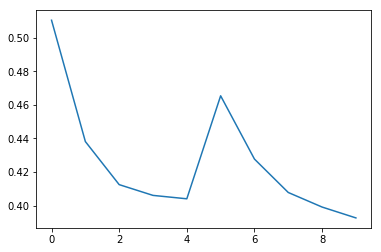

In [52]:
hist_epochs = np.mean(hist, axis=0)
plt.plot(hist_epochs);